
=== Processing: zginacze_kciuk.csv ===



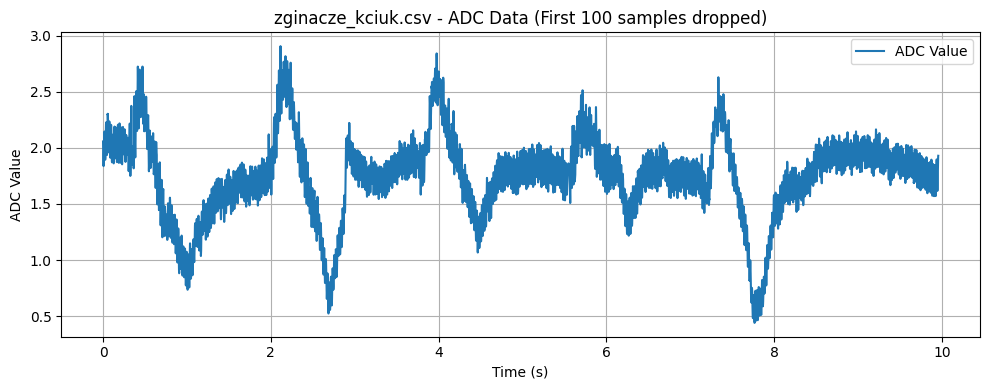

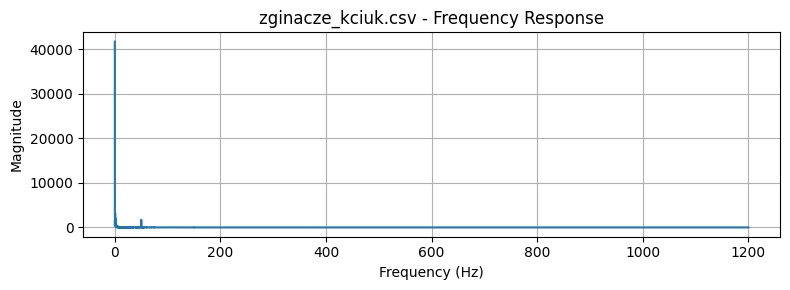

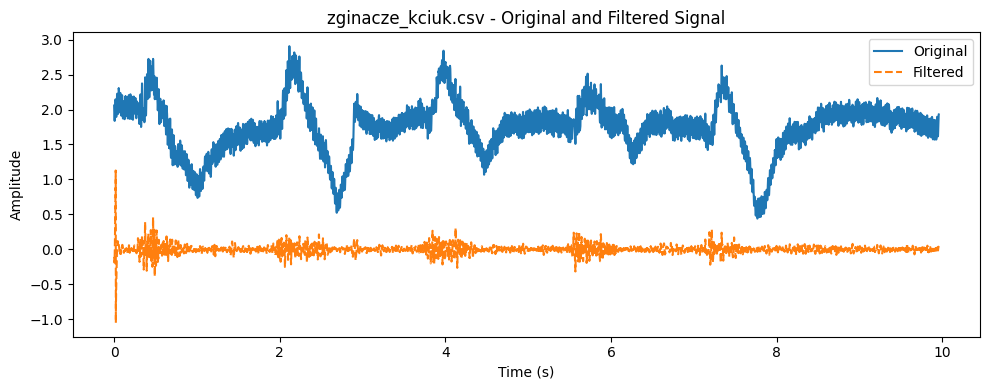

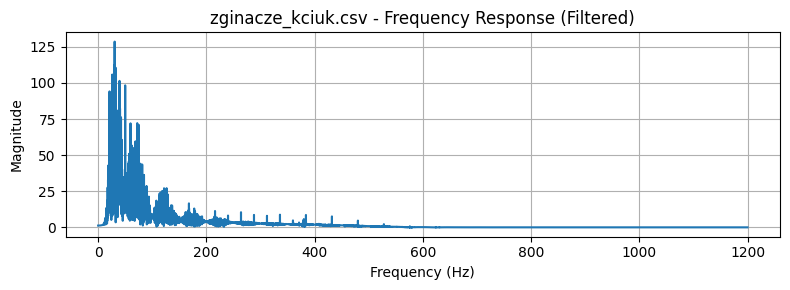

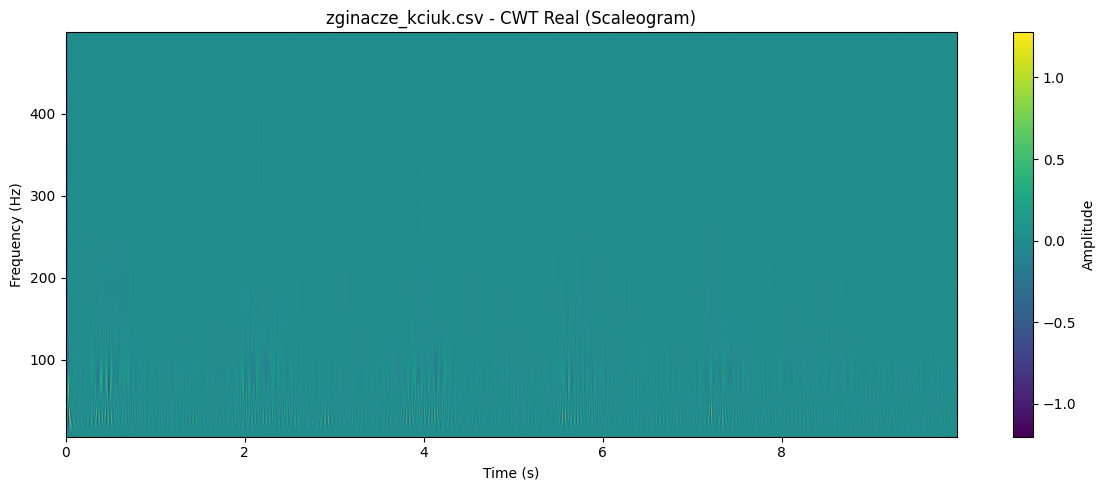


=== Processing: zginacze_luz.csv ===



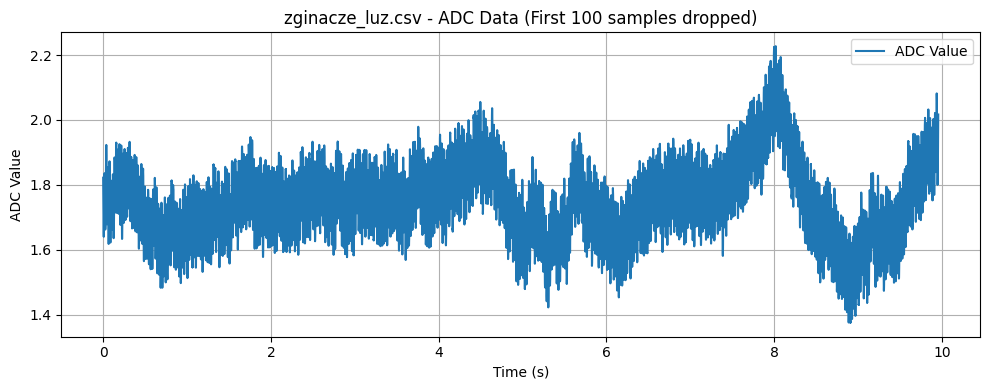

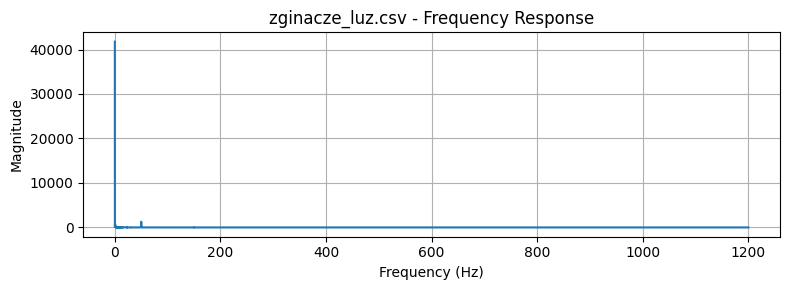

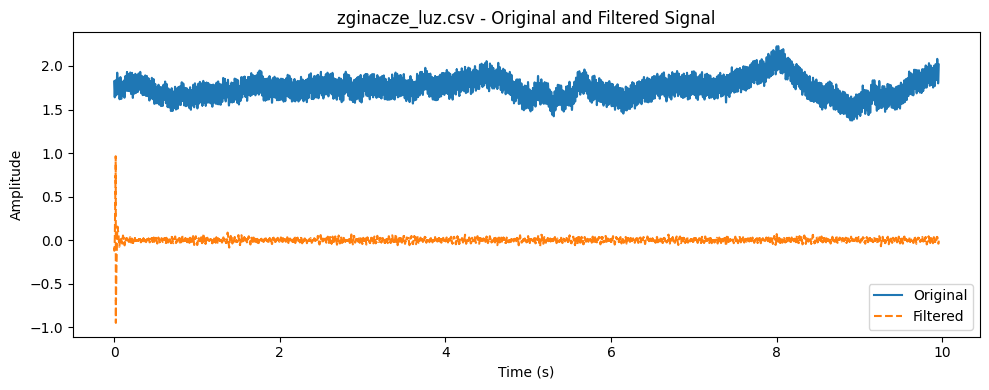

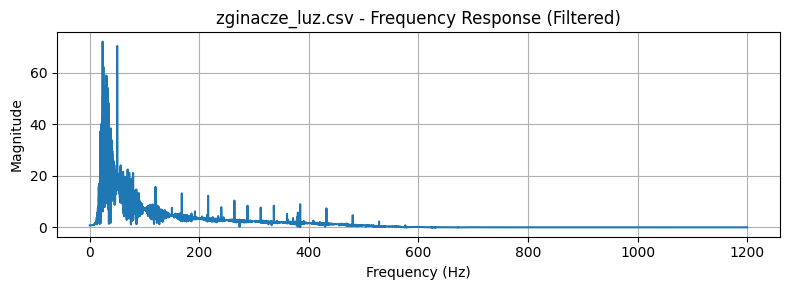

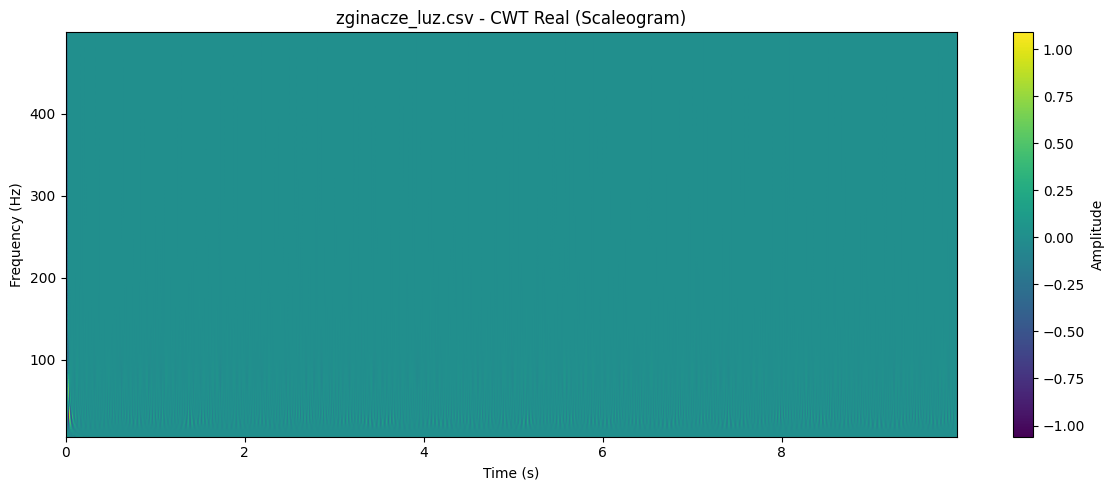


=== Processing: zginacze_maly.csv ===



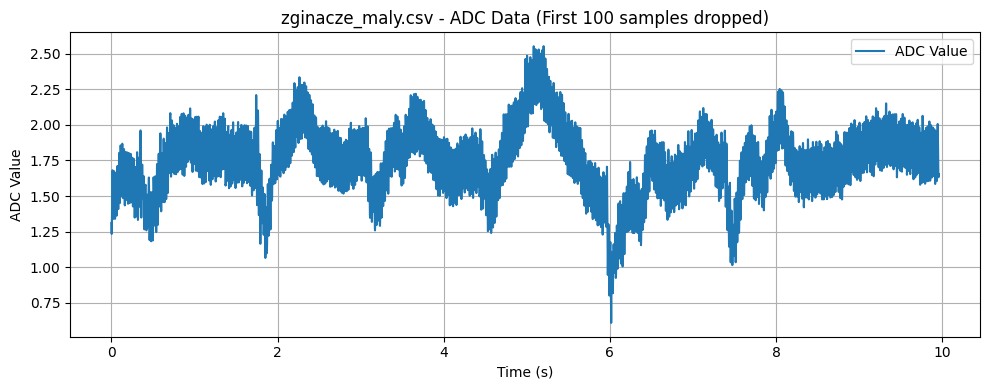

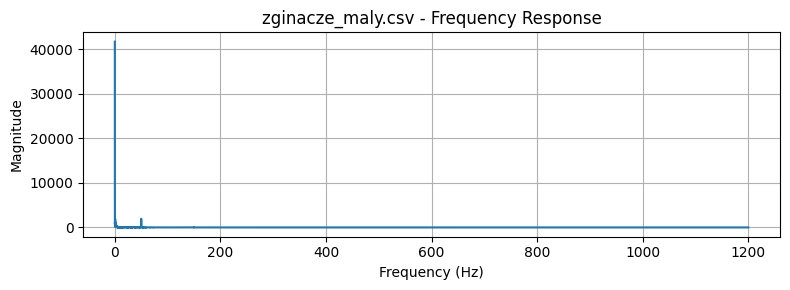

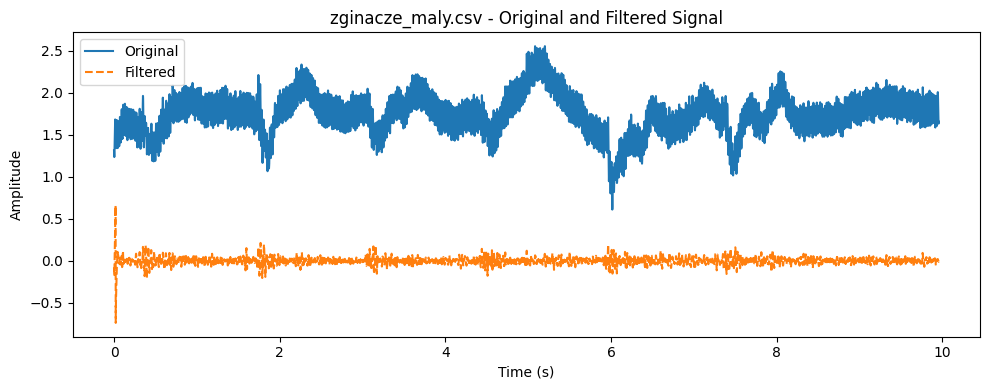

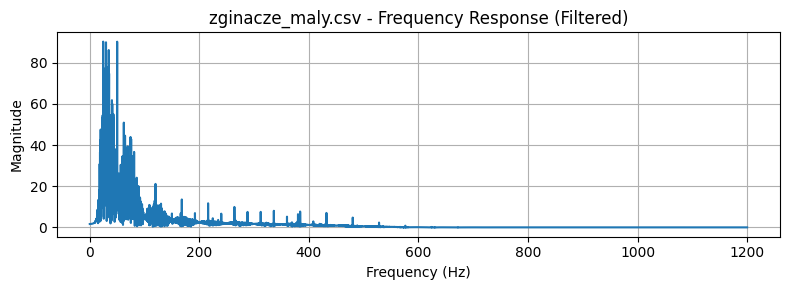

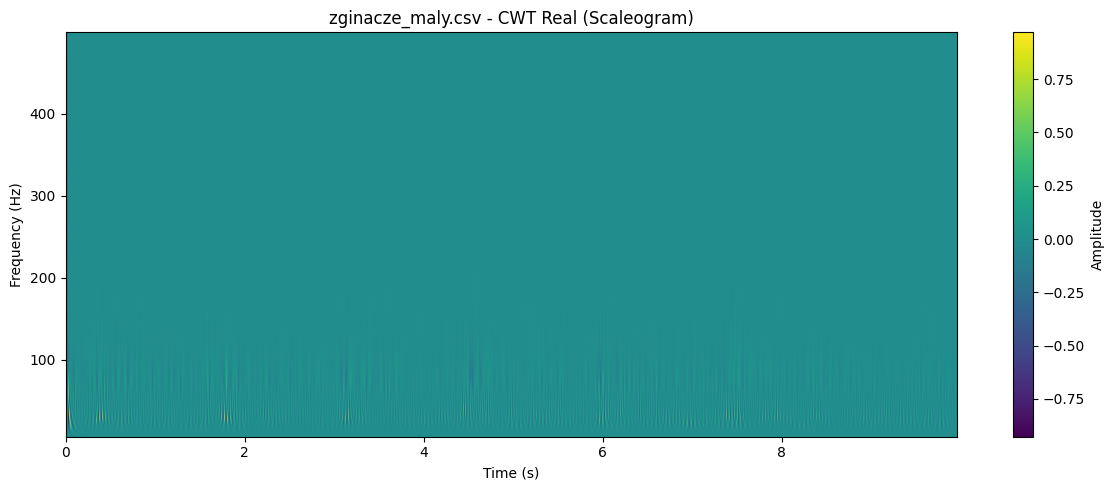


=== Processing: zginacze_serdeczny.csv ===



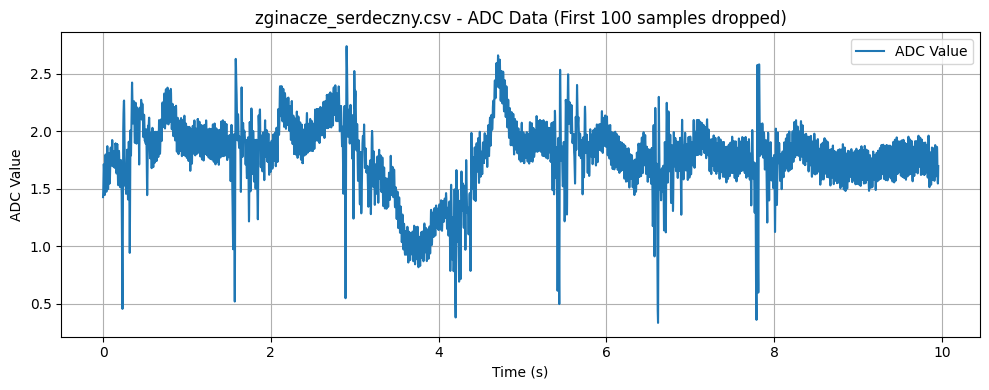

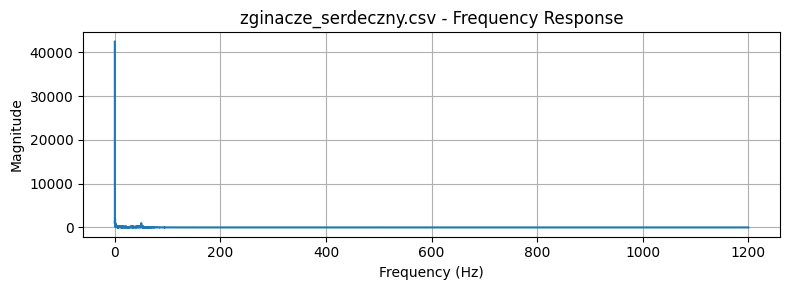

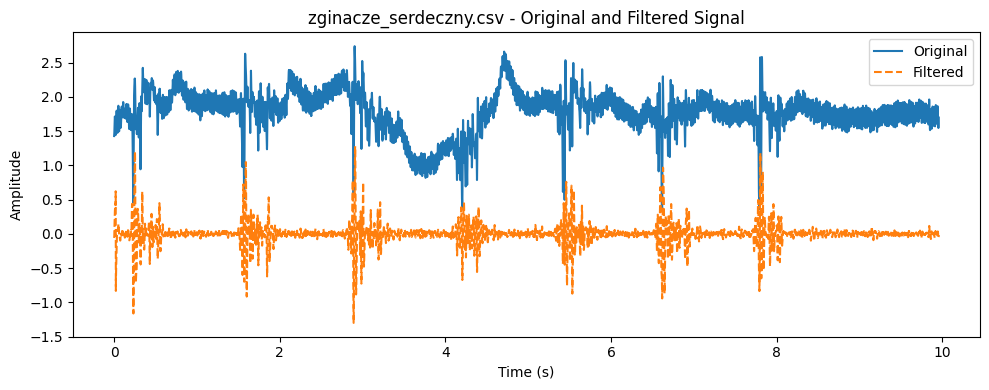

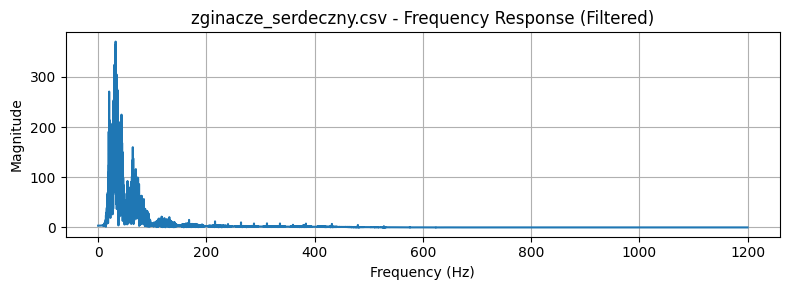

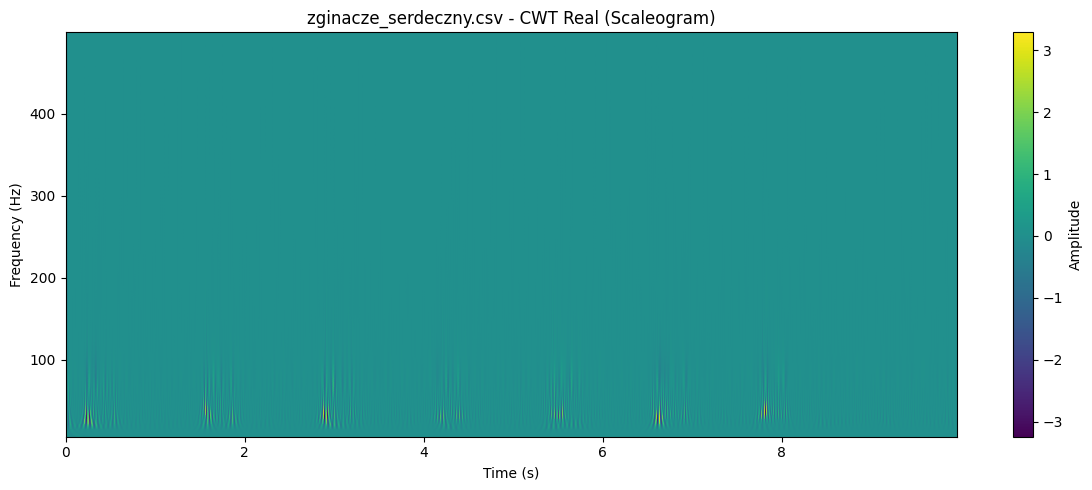


=== Processing: zginacze_srodkowy.csv ===



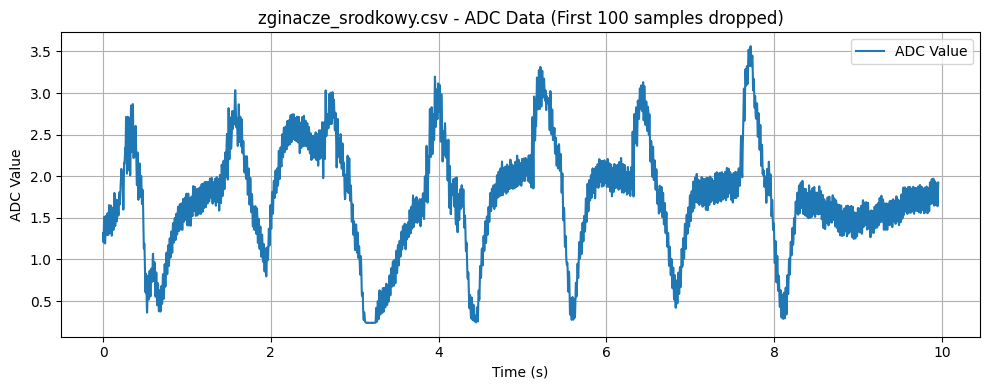

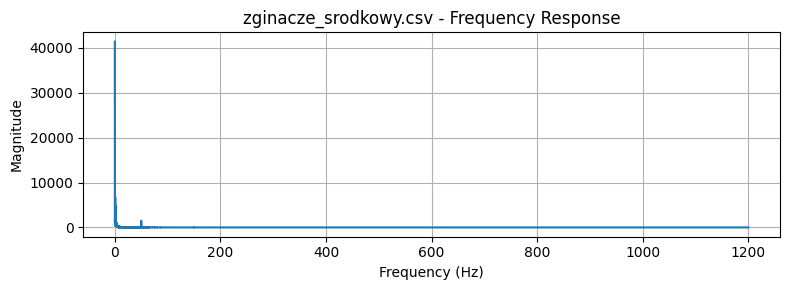

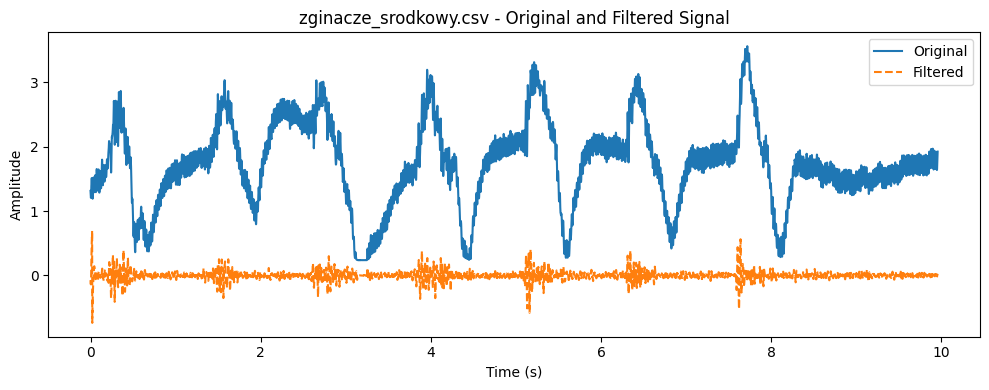

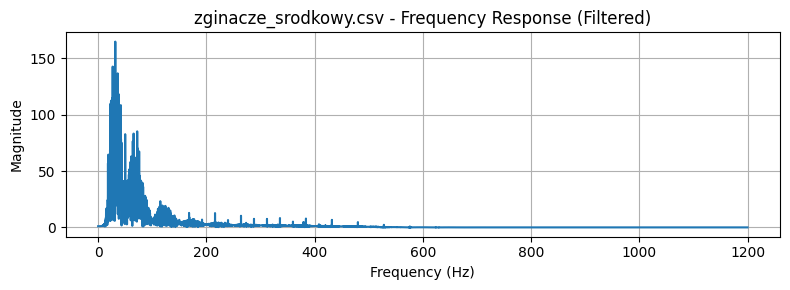

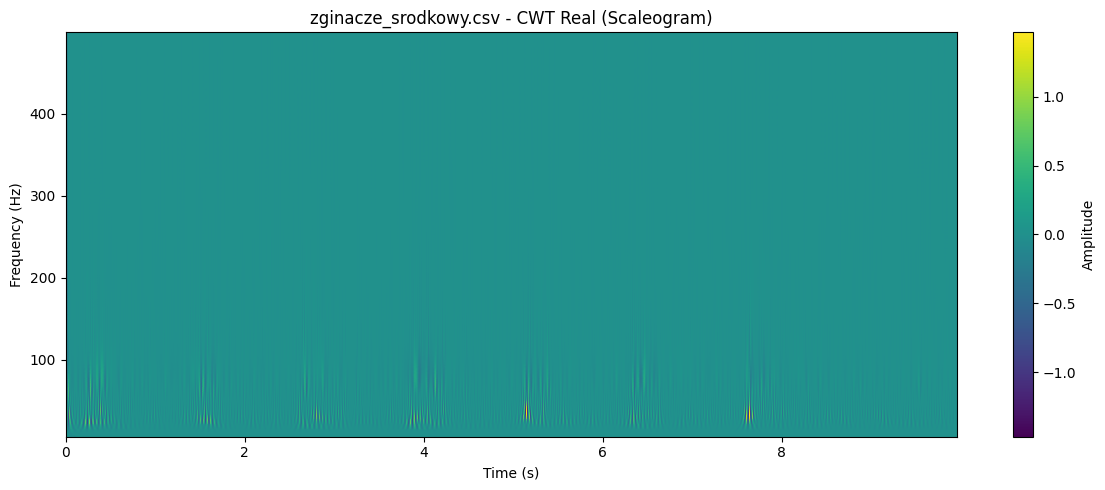


=== Processing: zginacze_wskazujacy.csv ===



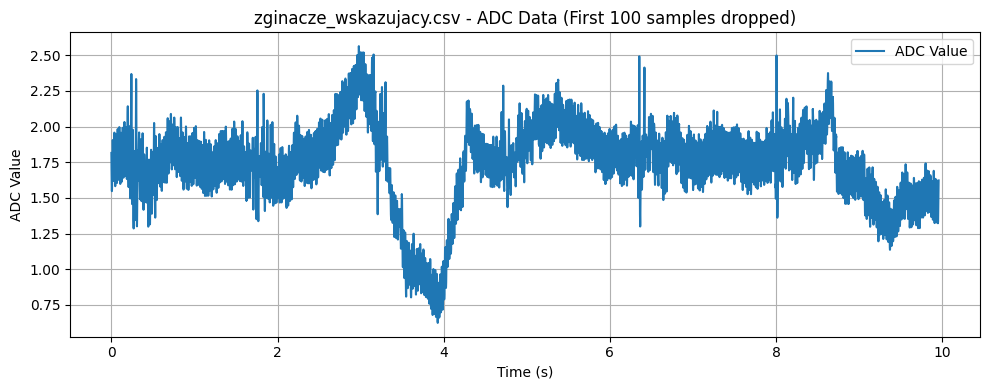

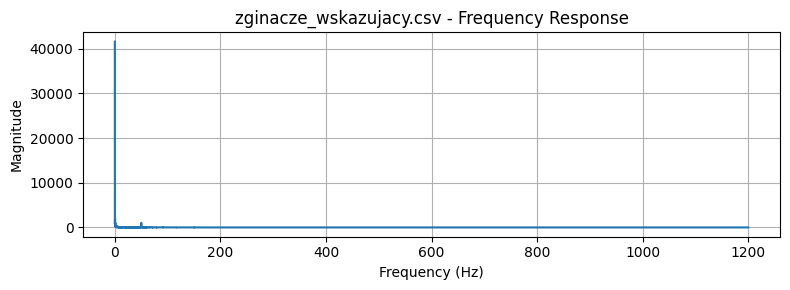

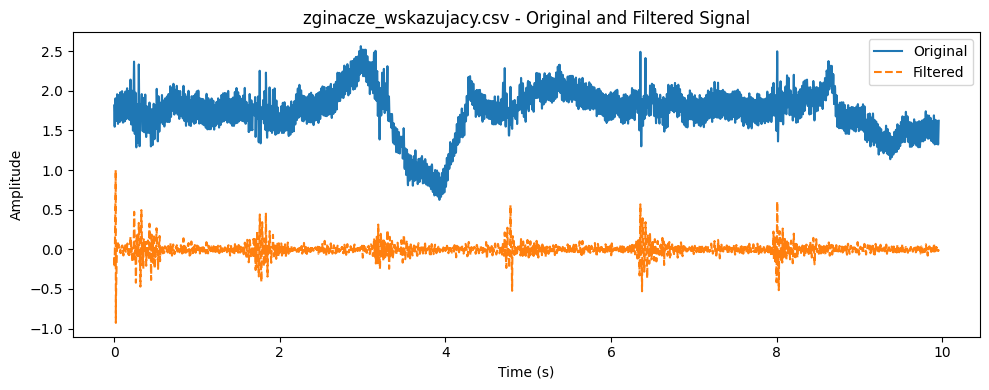

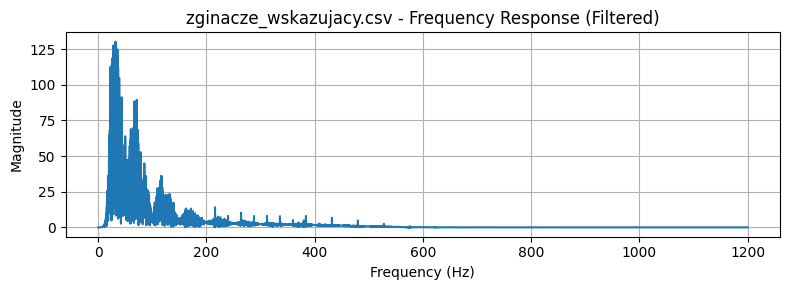

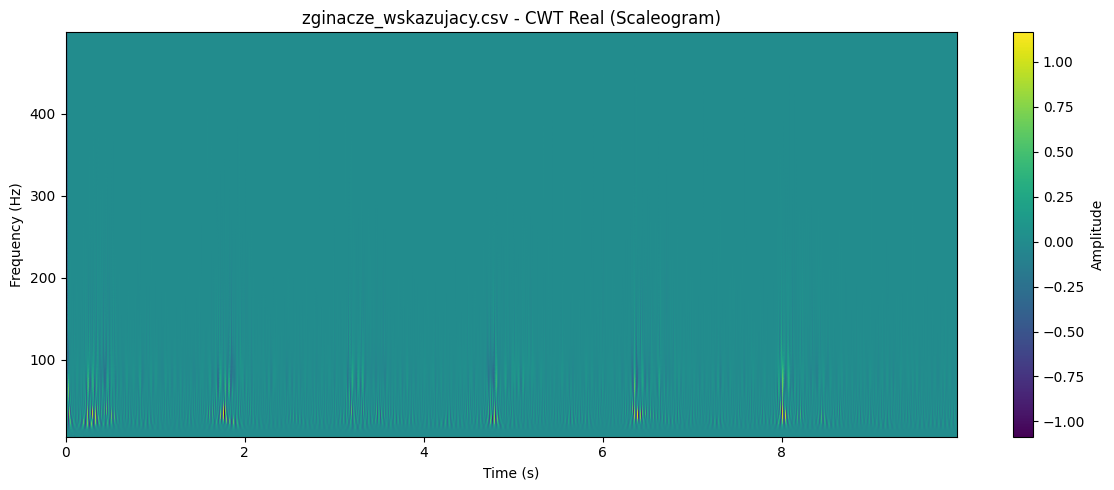


=== Processing: zginacze_wyprost.csv ===



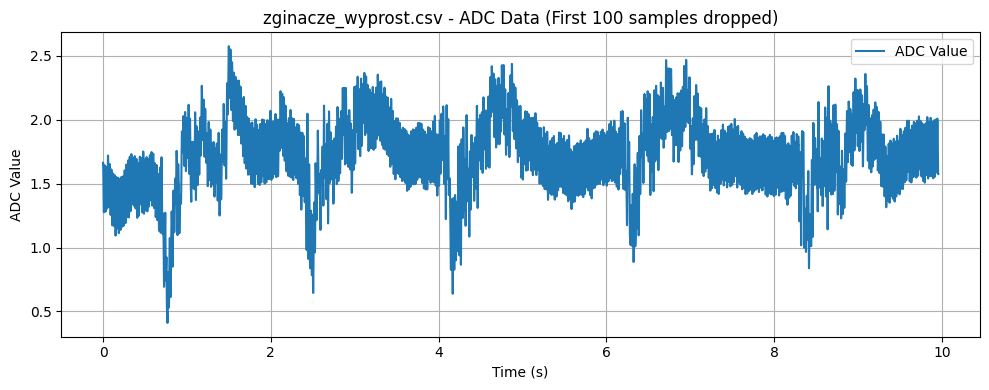

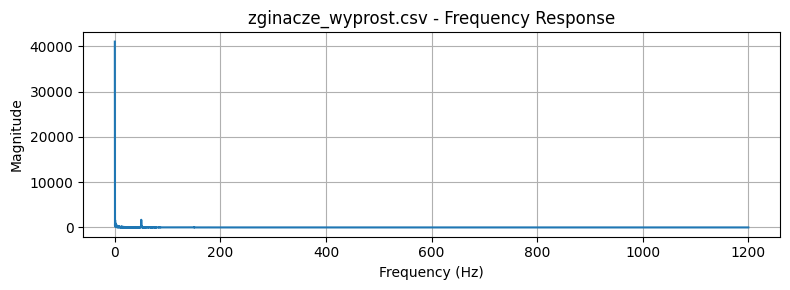

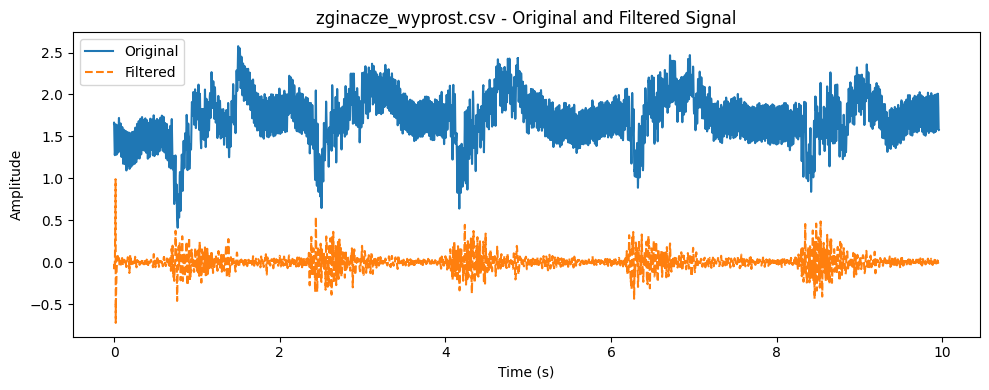

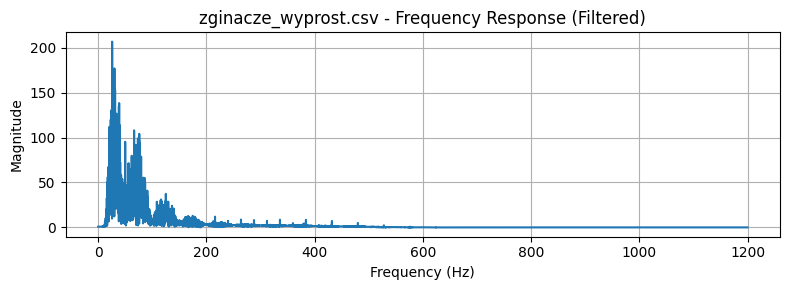

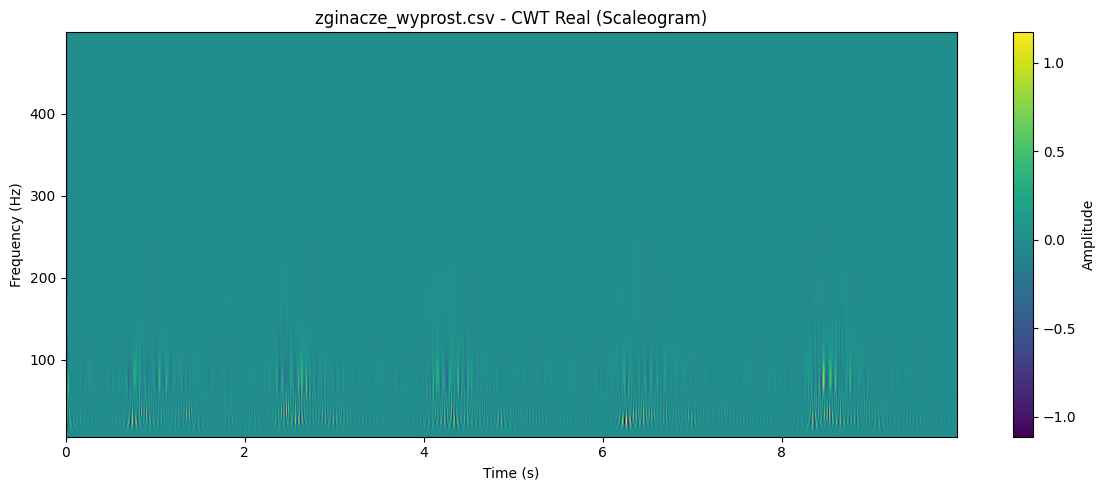


=== Processing: zginacze_zamkniecie_reki.csv ===



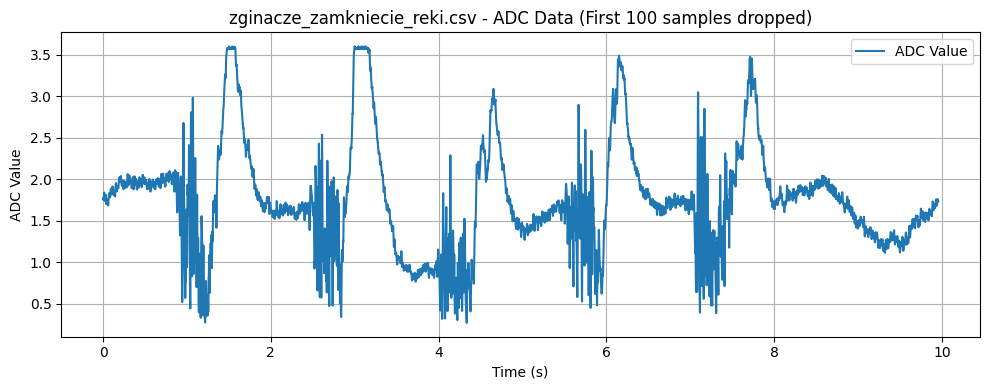

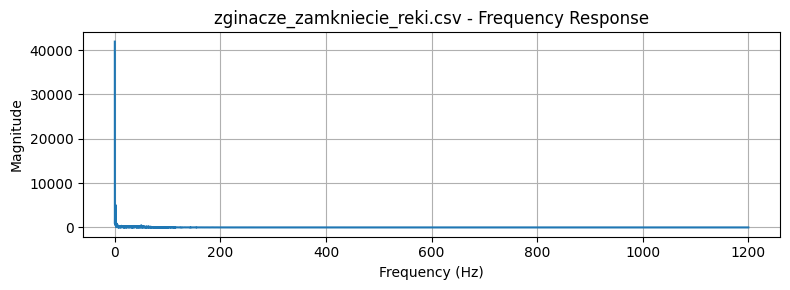

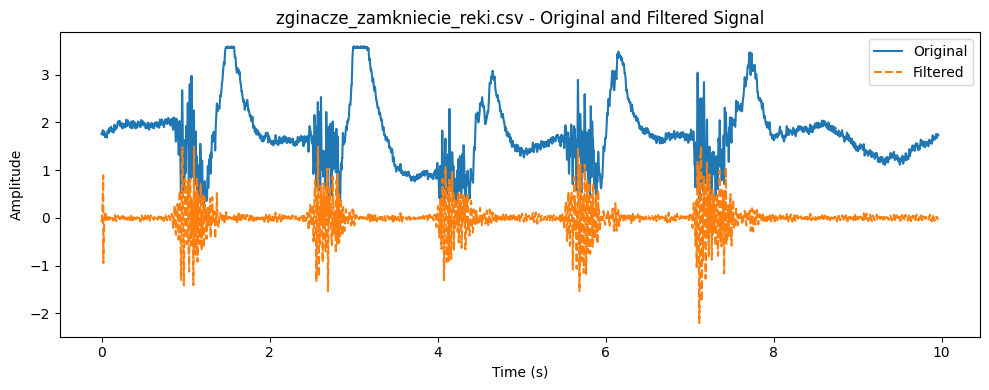

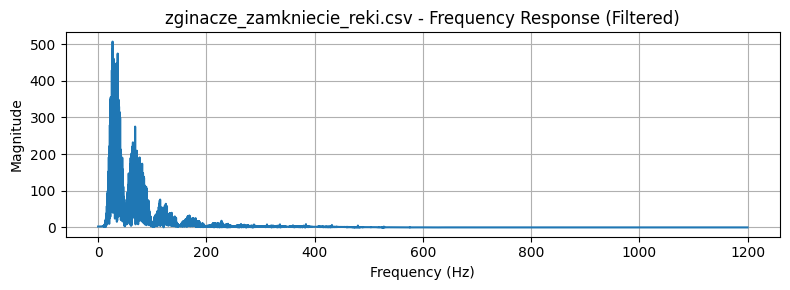

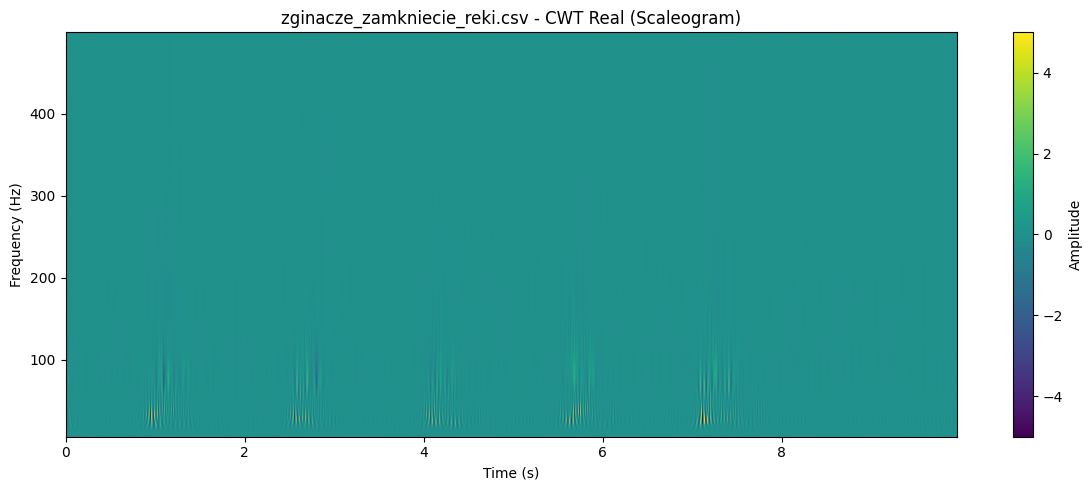

In [2]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, lfilter
import pywt

# Parameters
sampling_rate = 2400  # Hz
fs = sampling_rate

# Find all relevant files
csv_files = sorted(glob.glob("zginacze_*.csv"))

for filename in csv_files:
    print(f"\n=== Processing: {filename} ===\n")
    # Load ADC values (single column)
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / sampling_rate

    # Plot raw signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, adc_values, label='ADC Value')
    plt.xlabel('Time (s)')
    plt.ylabel('ADC Value')
    plt.title(f'{filename} - ADC Data (First 100 samples dropped)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # FFT of the original signal
    n = len(adc_values)
    fft_signal = np.fft.fft(adc_values)
    fft_freq = np.fft.fftfreq(n, d=1/fs)
    plt.figure(figsize=(8, 3))
    plt.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
    plt.title(f"{filename} - Frequency Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Comb filter
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)

    # Bandpass filter
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)

    # Plot original and filtered
    plt.figure(figsize=(10, 4))
    plt.plot(time, adc_values, label='Original')
    plt.plot(time, filtered_signal, label='Filtered', linestyle='--')
    plt.title(f"{filename} - Original and Filtered Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # FFT of filtered signal
    n = len(filtered_signal)
    fft_signal = np.fft.fft(filtered_signal)
    fft_freq = np.fft.fftfreq(n, d=1/fs)
    plt.figure(figsize=(8, 3))
    plt.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
    plt.title(f"{filename} - Frequency Response (Filtered)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)

    # Plot CWT scaleogram
    plt.figure(figsize=(12, 5))
    plt.pcolormesh(time, freqs, np.real(cwtmatr[:-1, :-1]), shading='auto')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"{filename} - CWT Real (Scaleogram)")
    plt.colorbar(label='Amplitude')
    plt.tight_layout()
    plt.show()

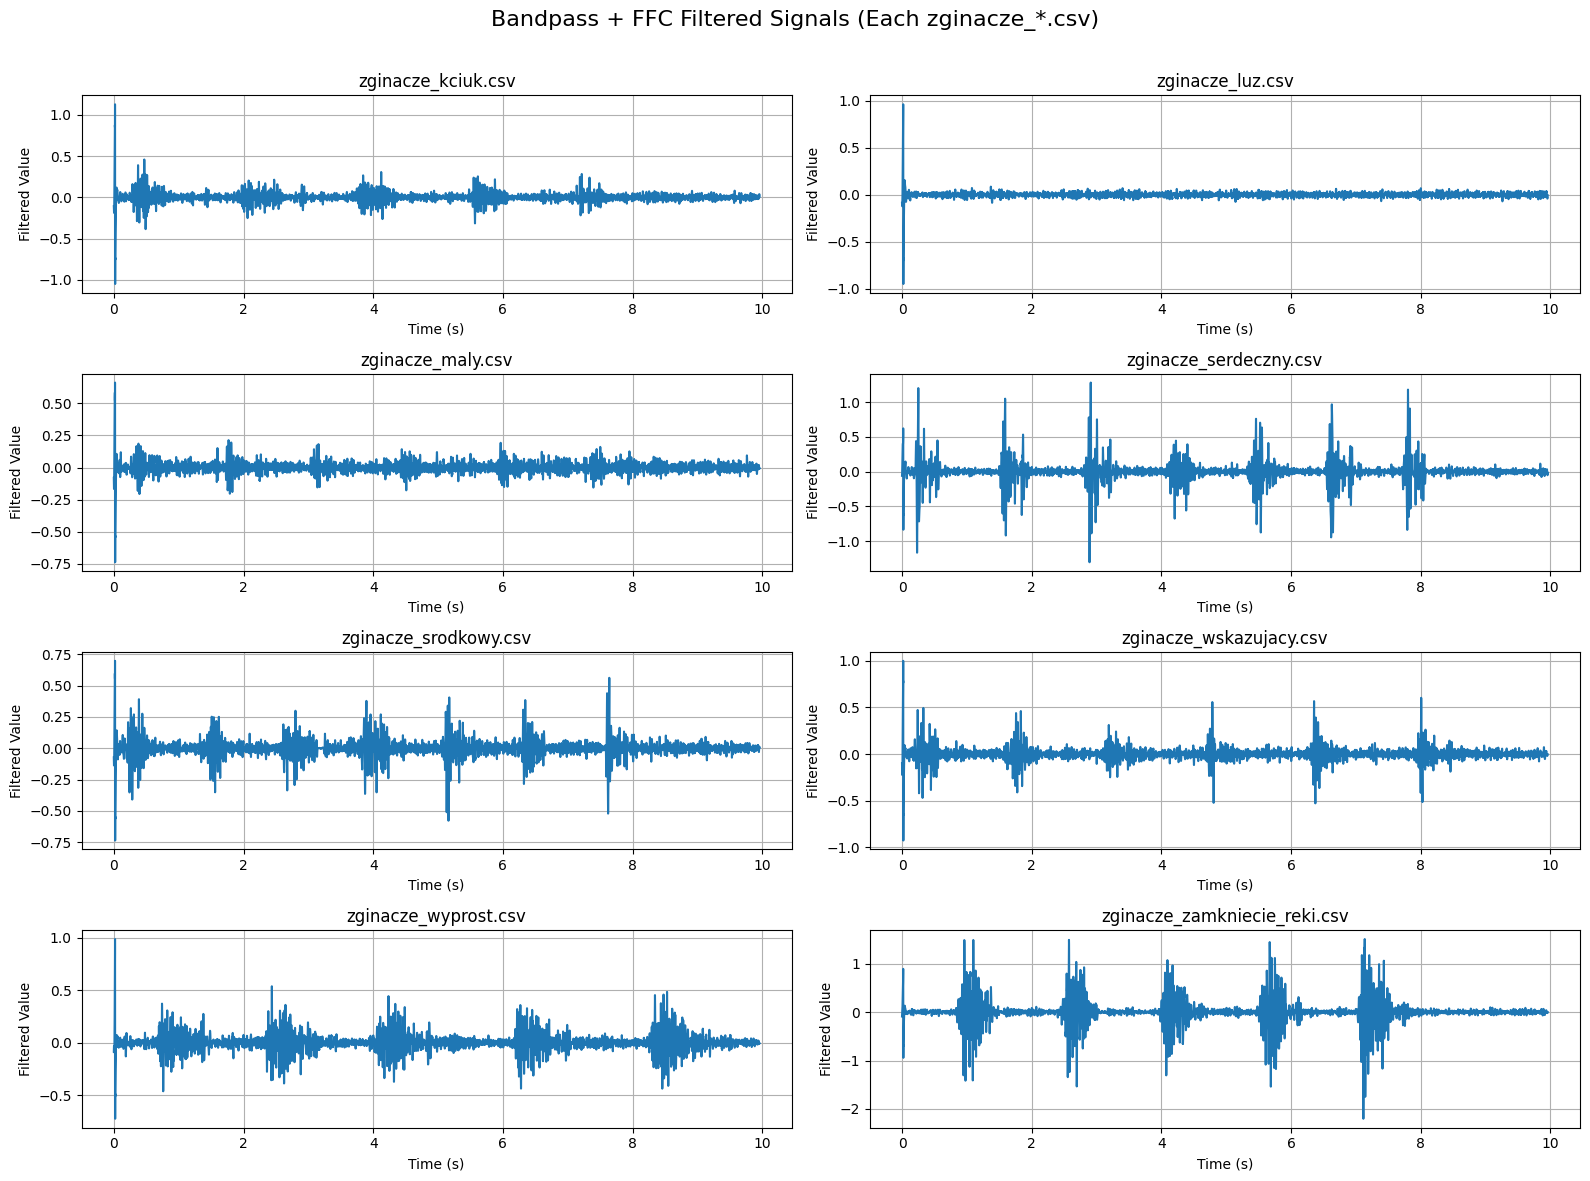

In [10]:
import math

filtered_signals = []
filtered_times = []
filtered_labels = []

for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    filtered_signals.append(filtered_signal)
    filtered_times.append(time)
    filtered_labels.append(filename)

# Plot all filtered signals in separate subplots in one figure
num_files = len(csv_files)
cols = 2  # or 3, depending on your preference
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 3*rows), sharex=False)
axs = axs.flatten()

for i in range(num_files):
    axs[i].plot(filtered_times[i], filtered_signals[i])
    axs[i].set_title(filtered_labels[i])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Filtered Value")
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_files, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Bandpass + FFC Filtered Signals (Each zginacze_*.csv)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

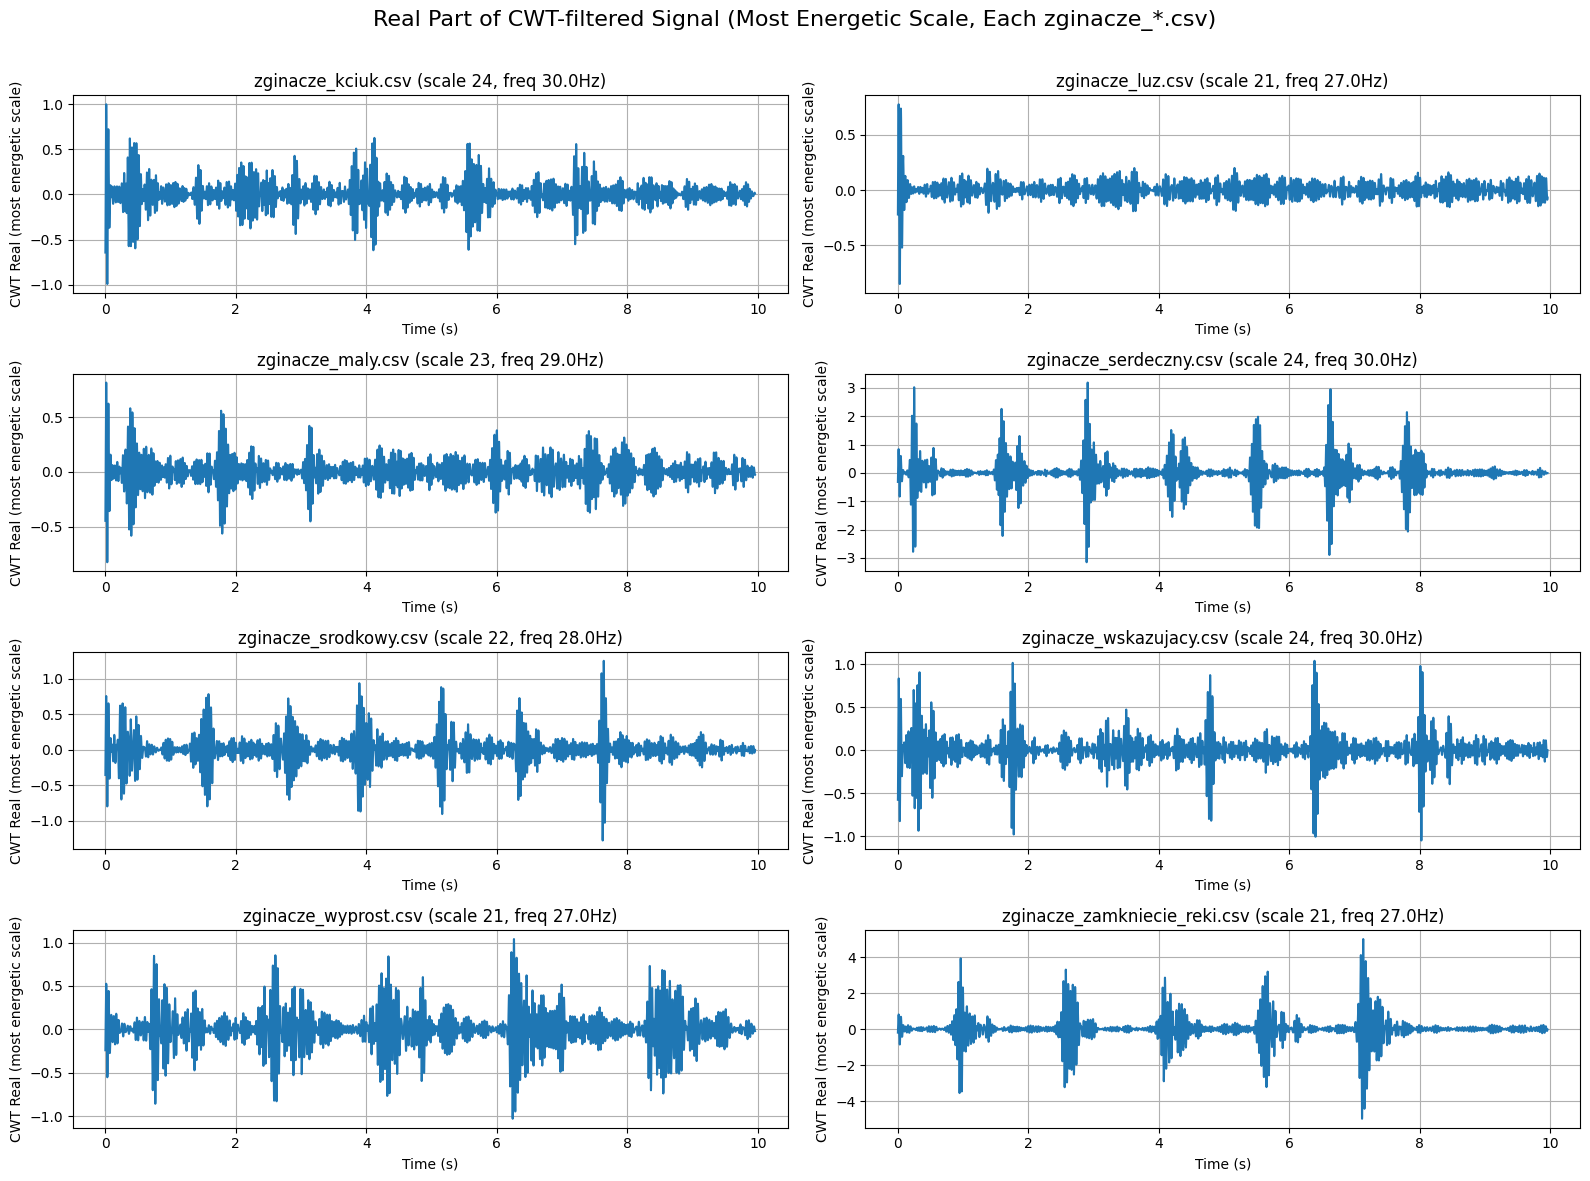

In [13]:
import math

cwt_real_signals = []
cwt_times = []
cwt_labels = []
selected_scales = []

for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: comb + bandpass
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    # Select the most energetic scale
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    selected_scales.append(best_scale_idx)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    cwt_real_signals.append(real_cwt)
    cwt_times.append(time)
    cwt_labels.append(f"{filename} (scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)")

# Plot all CWT-real signals in separate subplots in one figure
num_files = len(csv_files)
cols = 2
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 3*rows), sharex=False)
axs = axs.flatten()

for i in range(num_files):
    axs[i].plot(cwt_times[i], cwt_real_signals[i])
    axs[i].set_title(cwt_labels[i])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("CWT Real (most energetic scale)")
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_files, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Real Part of CWT-filtered Signal (Most Energetic Scale, Each zginacze_*.csv)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

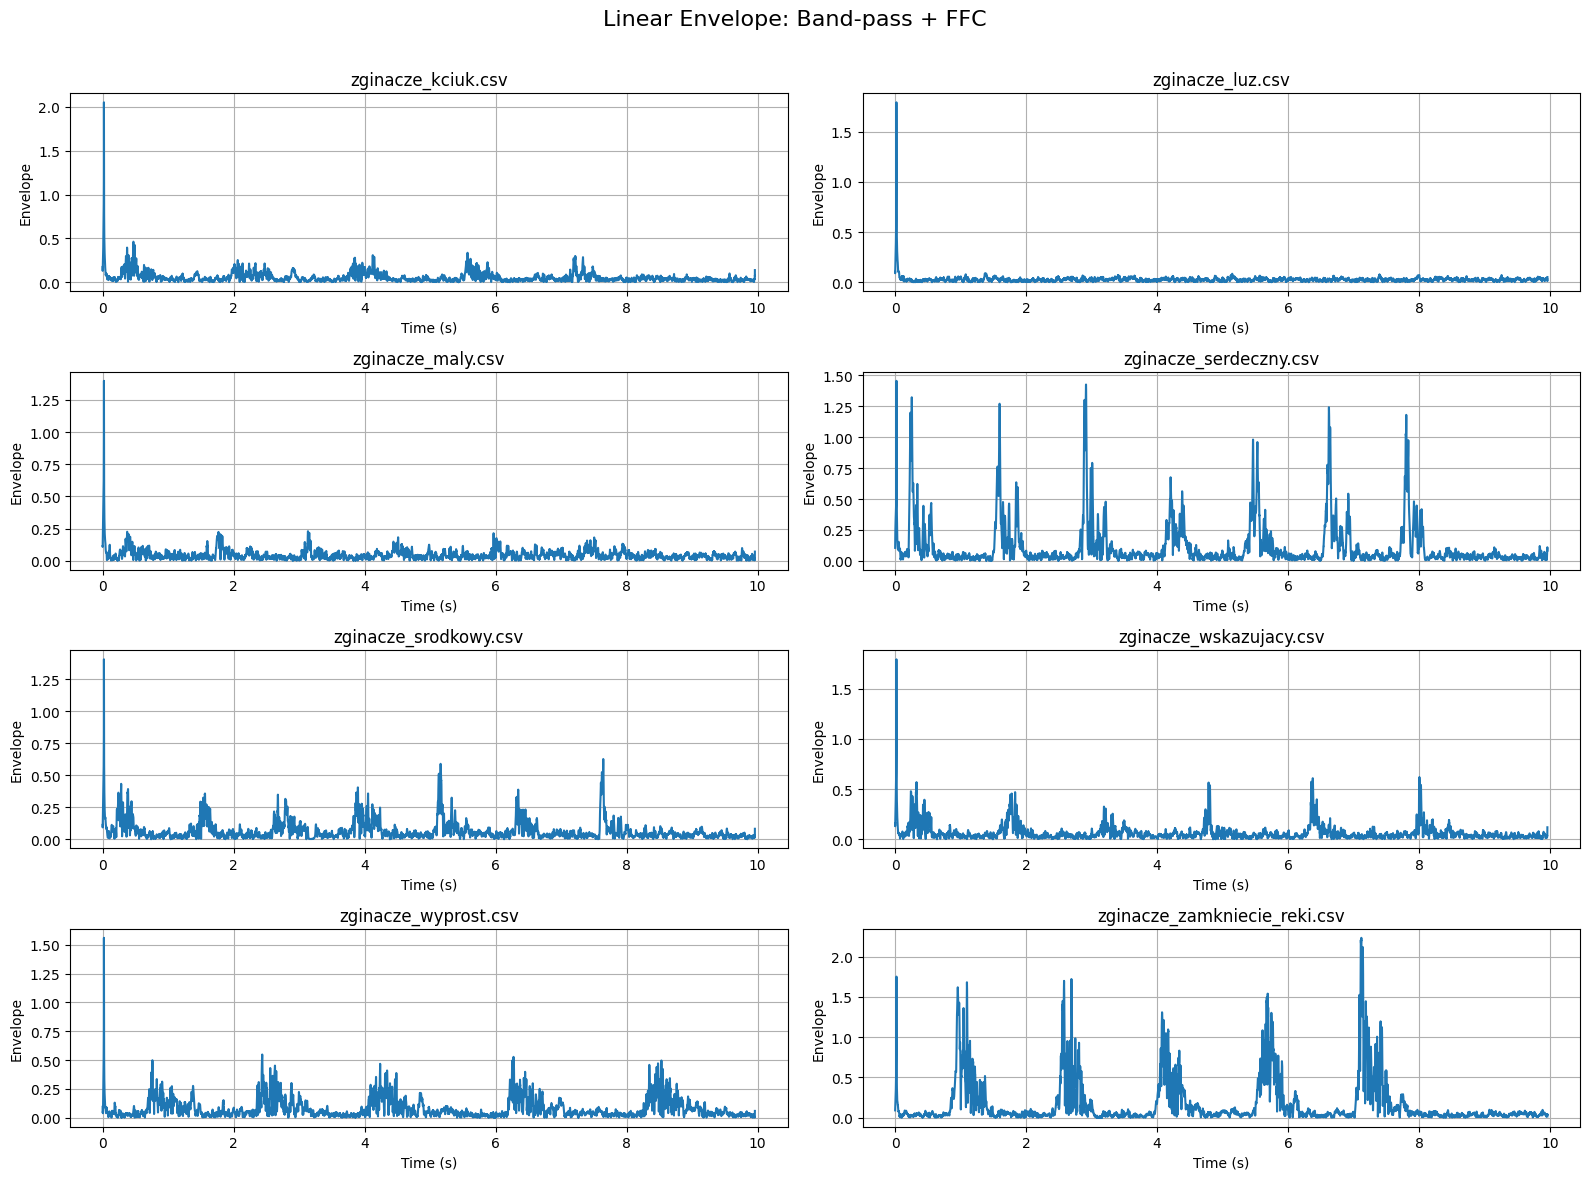

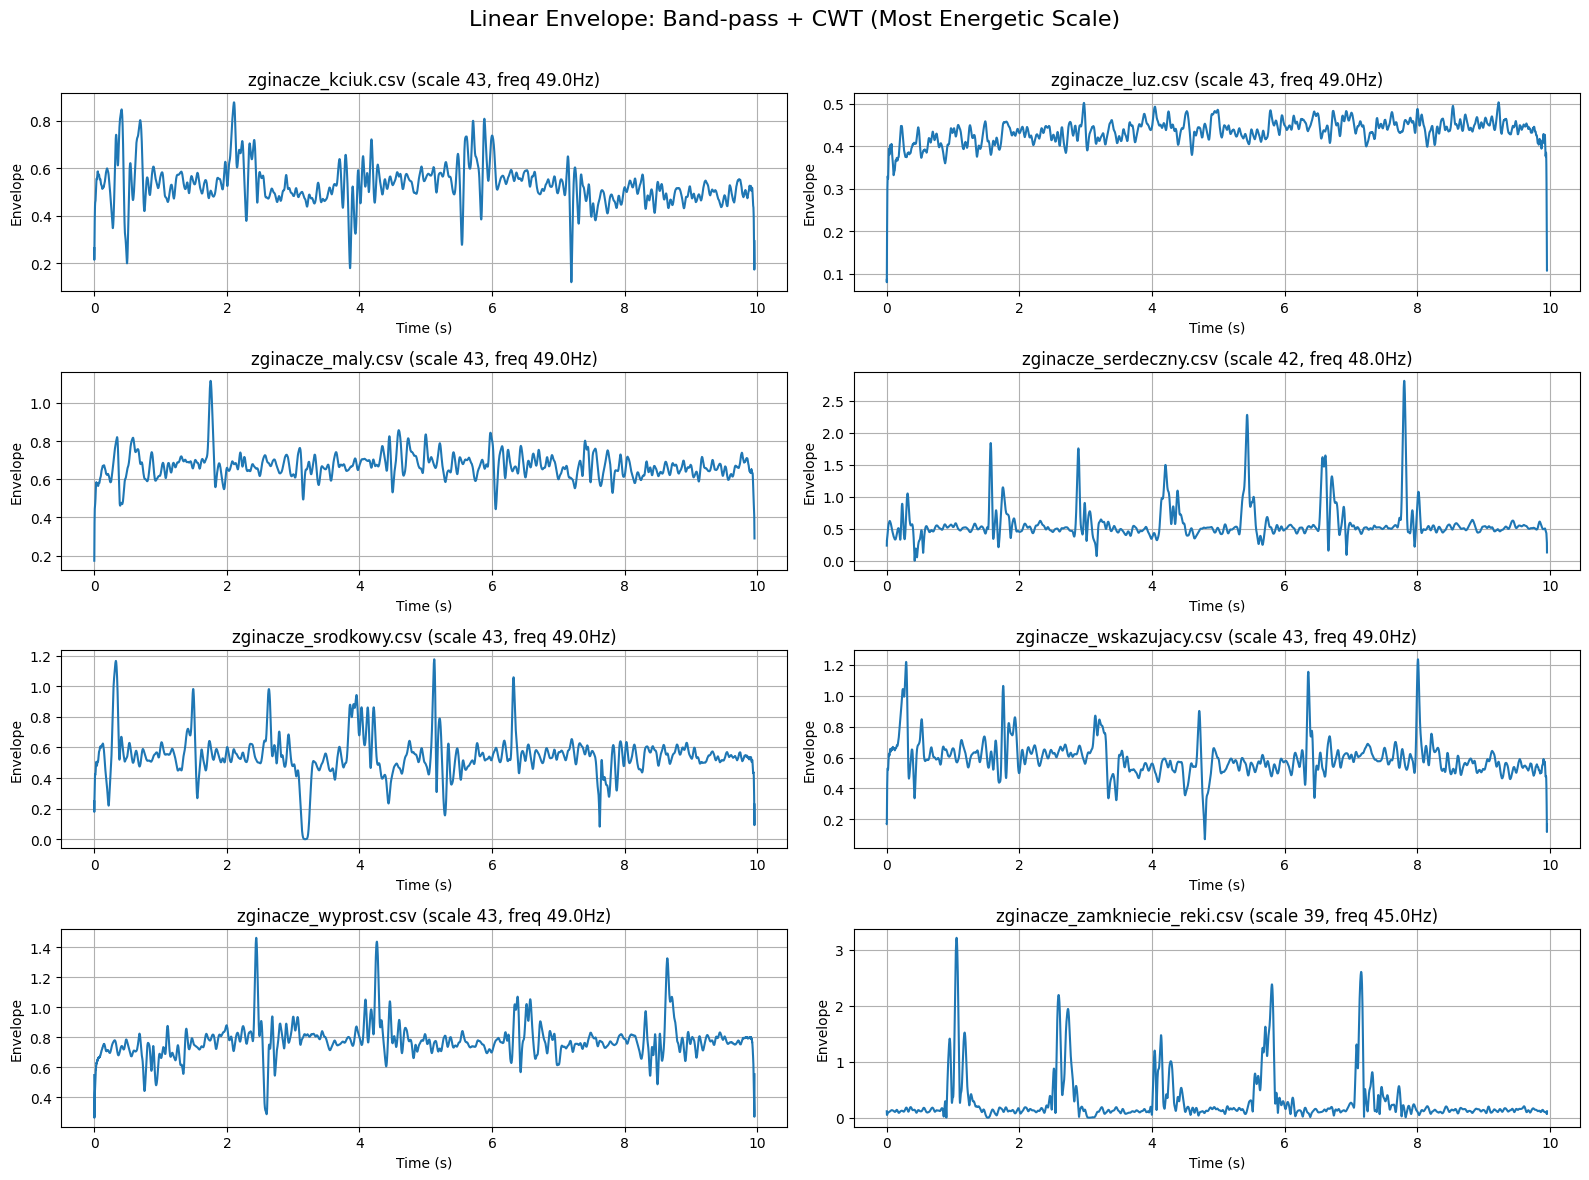

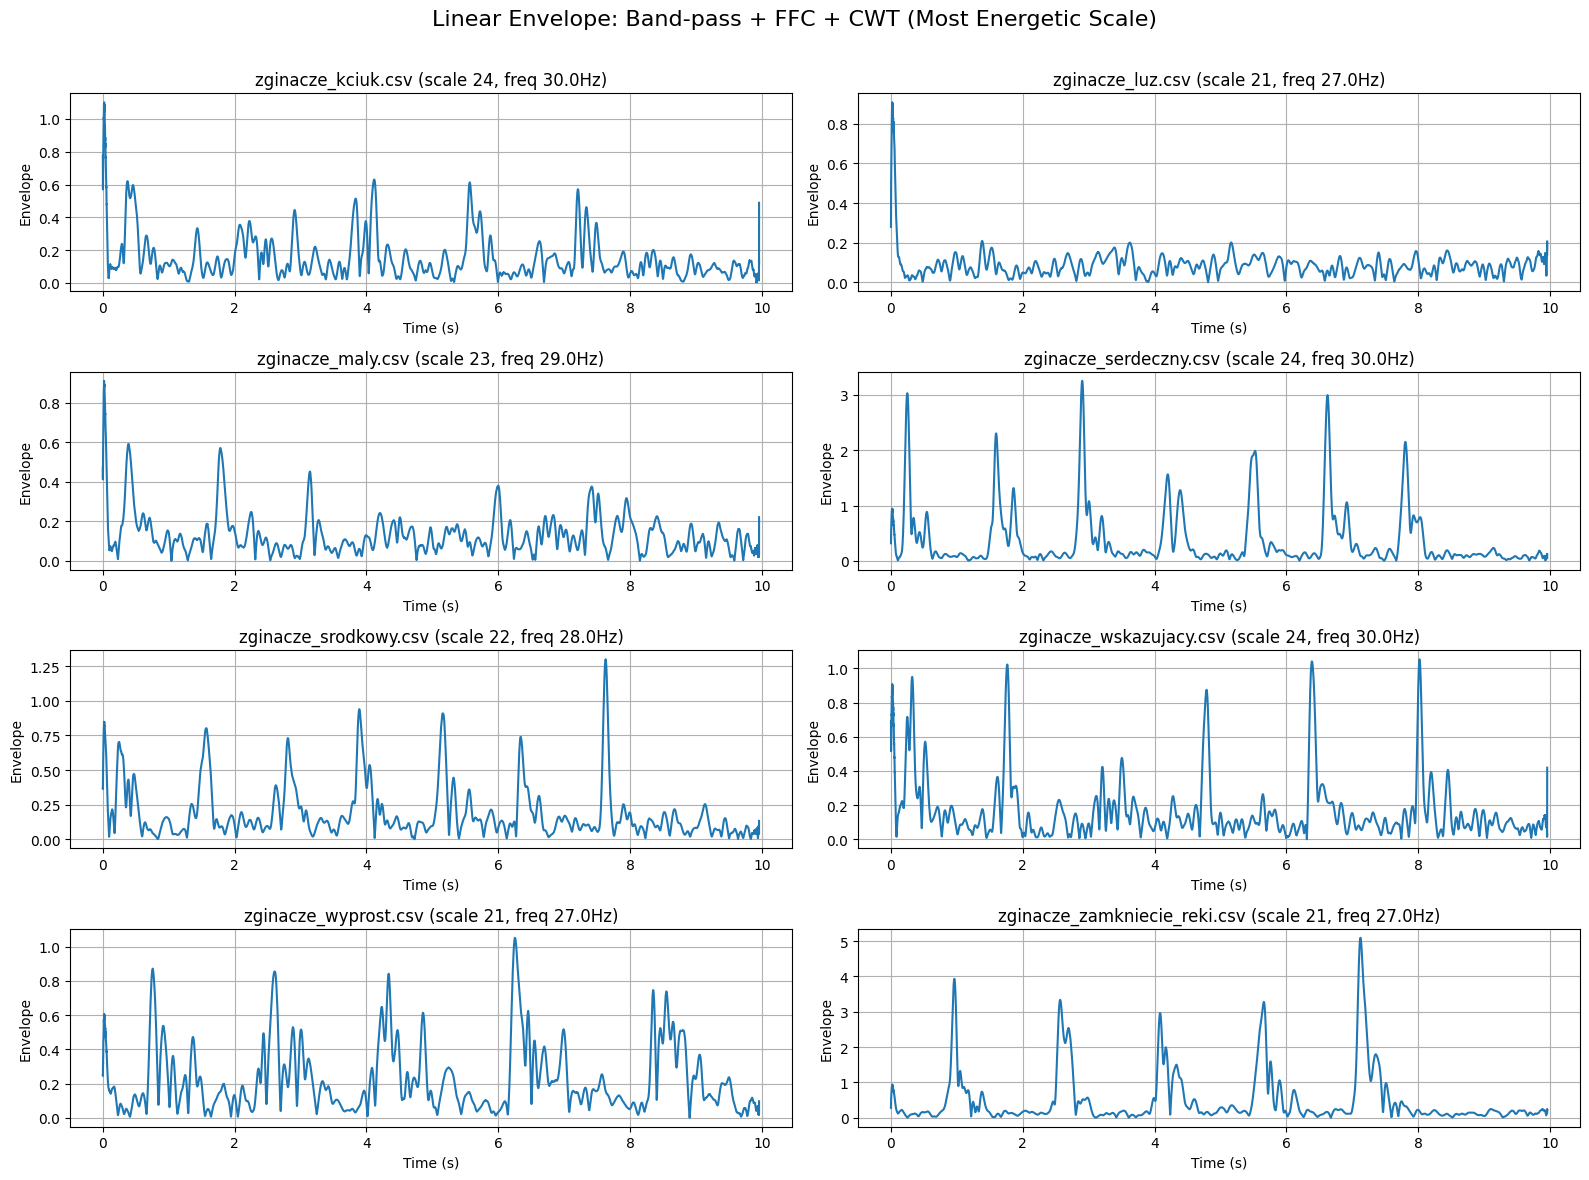

In [15]:
import math
from scipy.signal import hilbert

# --- 1. Linear envelope for Band-pass + FFC ---
envelopes_1 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: comb + bandpass
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    envelope = np.abs(hilbert(filtered_signal))
    envelopes_1.append((time, envelope, filename))

# --- 2. Linear envelope for Band-pass + CWT (most energetic scale) ---
envelopes_2 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: bandpass only
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, adc_values)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    envelope = np.abs(hilbert(real_cwt))
    envelopes_2.append((time, envelope, f"{filename} (scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)"))

# --- 3. Linear envelope for Band-pass + FFC + CWT (most energetic scale) ---
envelopes_3 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: comb + bandpass
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    envelope = np.abs(hilbert(real_cwt))
    envelopes_3.append((time, envelope, f"{filename} (scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)"))

# --- Plotting ---
def plot_envelopes(envelopes, title):
    num_files = len(envelopes)
    cols = 2
    rows = math.ceil(num_files / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 3*rows), sharex=False)
    axs = axs.flatten()
    for i, (time, envelope, label) in enumerate(envelopes):
        axs[i].plot(time, envelope)
        axs[i].set_title(label)
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Envelope")
        axs[i].grid(True)
    for j in range(num_files, len(axs)):
        fig.delaxes(axs[j])
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_envelopes(envelopes_1, "Linear Envelope: Band-pass + FFC")
plot_envelopes(envelopes_2, "Linear Envelope: Band-pass + CWT (Most Energetic Scale)")
plot_envelopes(envelopes_3, "Linear Envelope: Band-pass + FFC + CWT (Most Energetic Scale)")

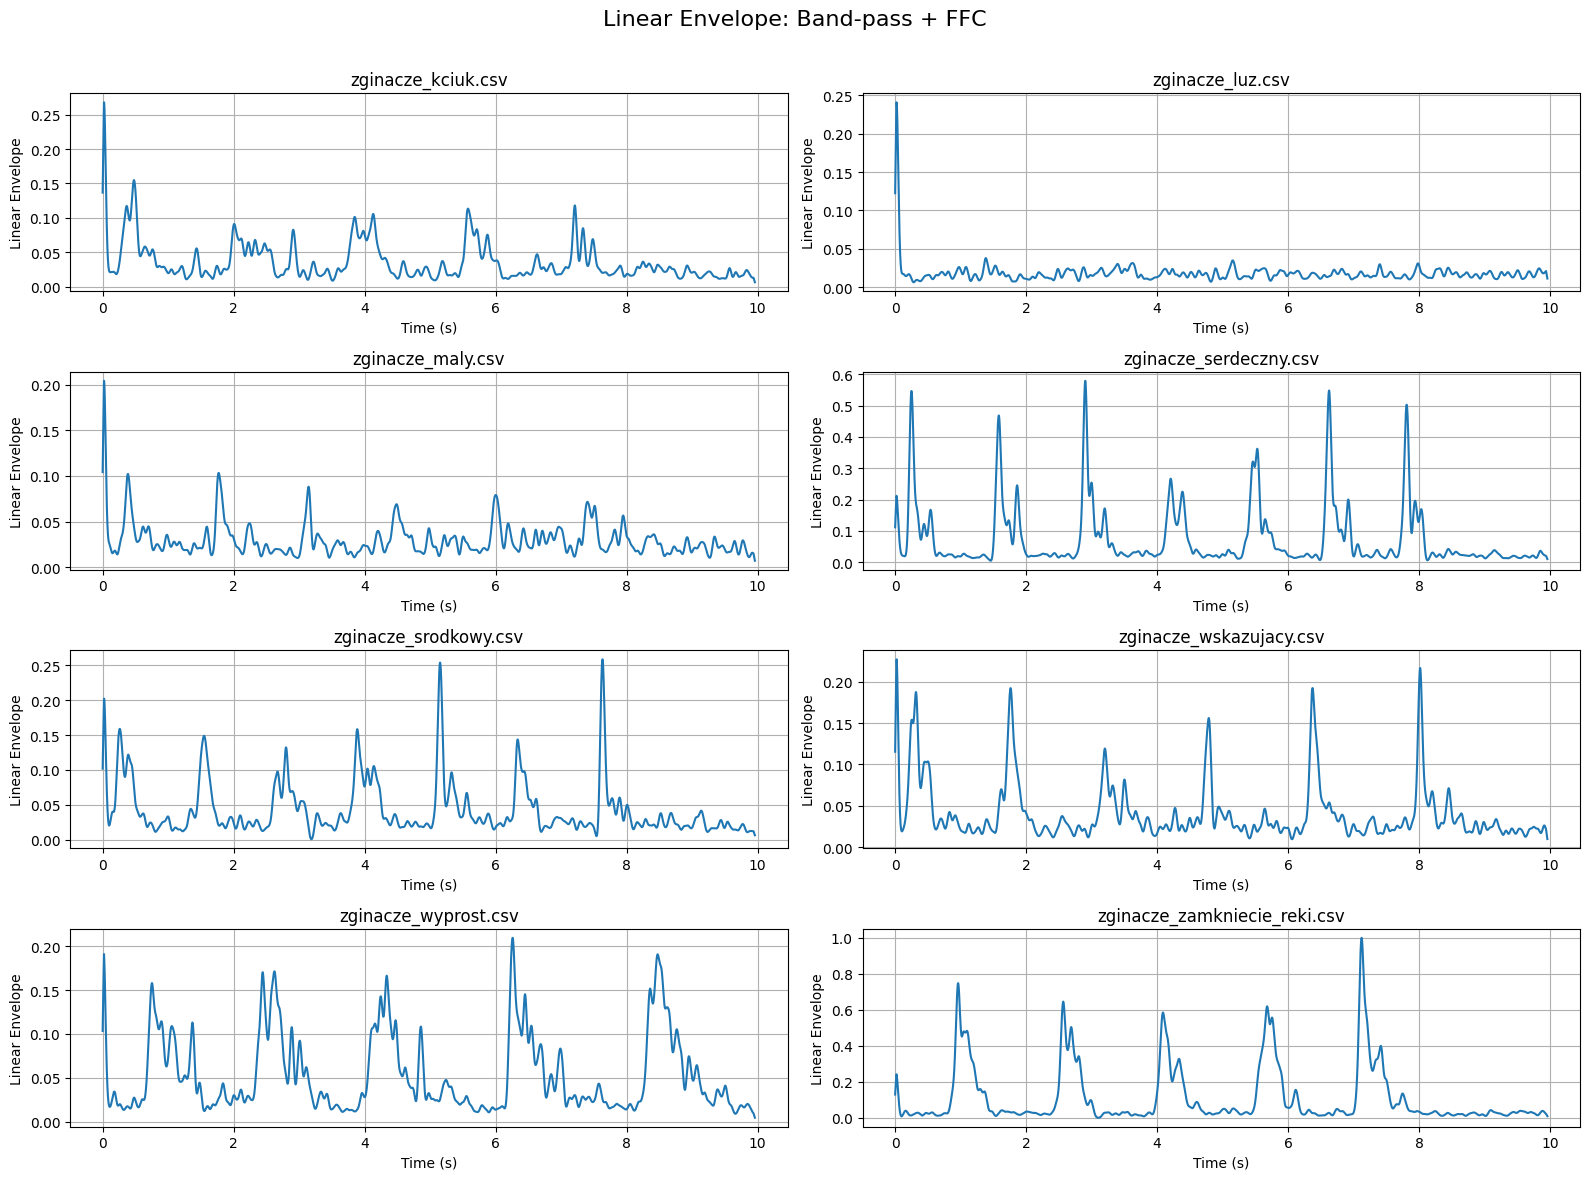

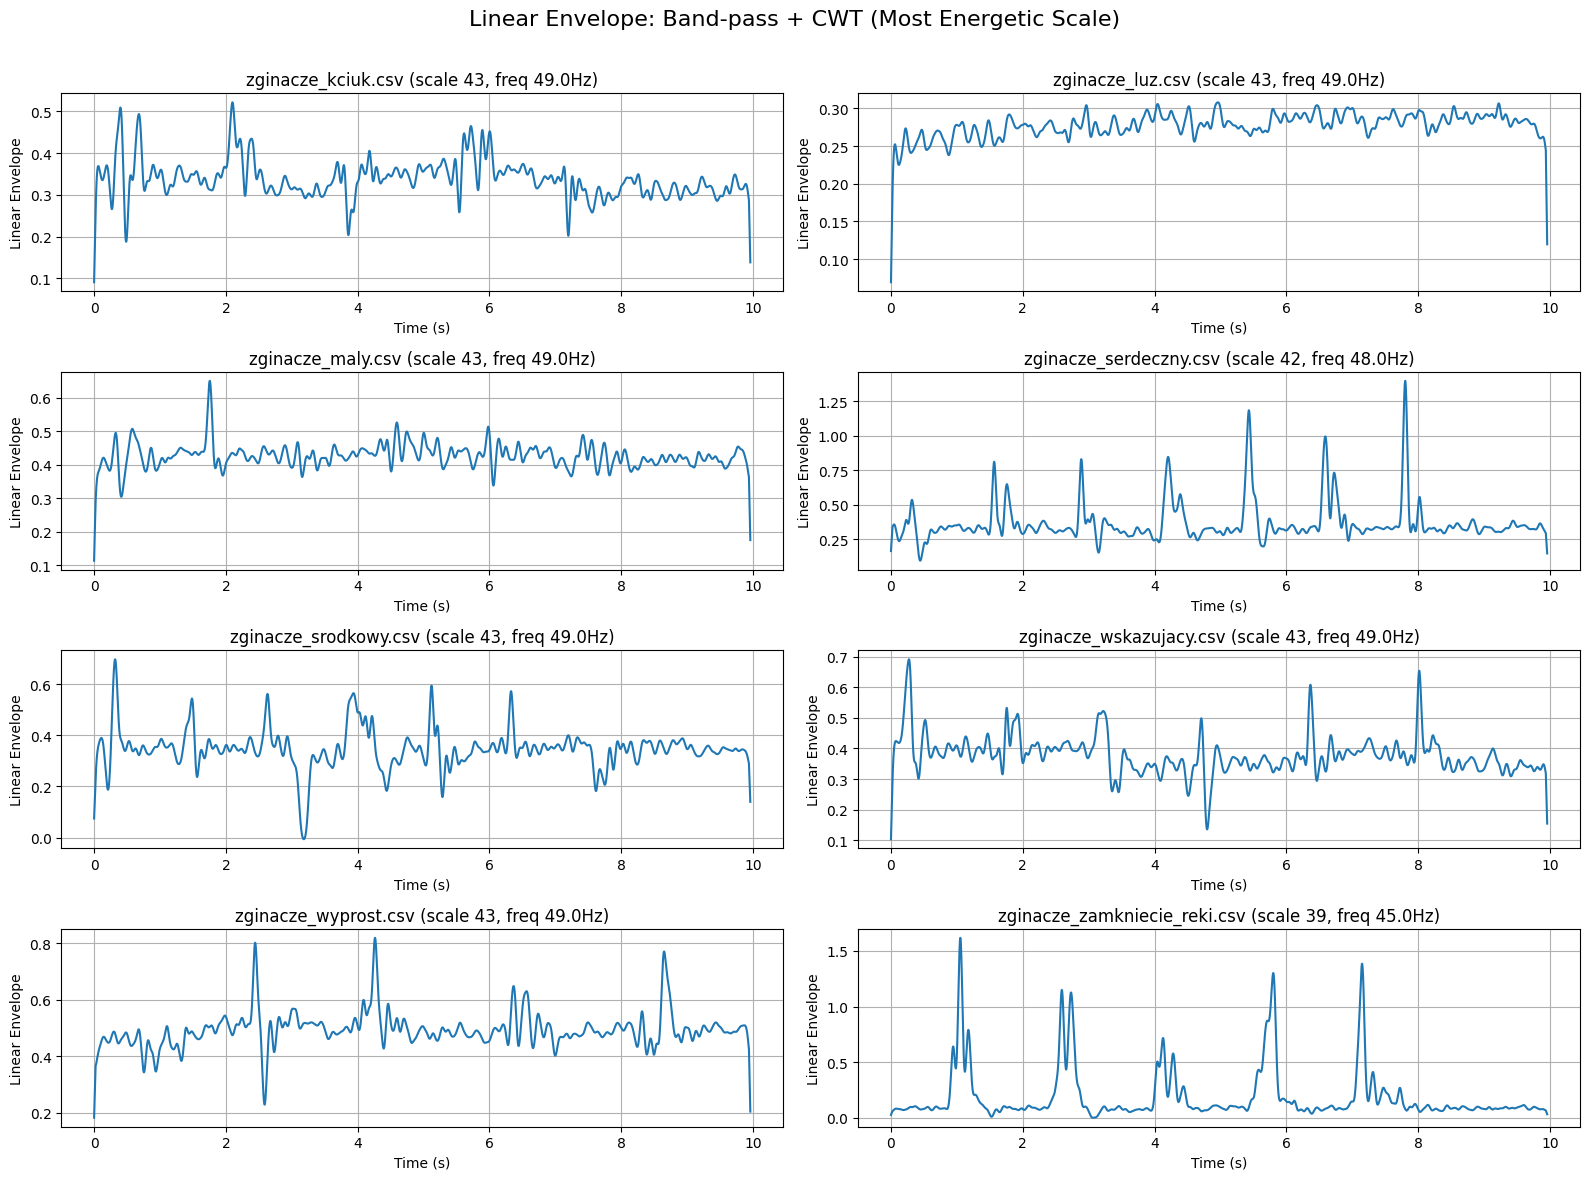

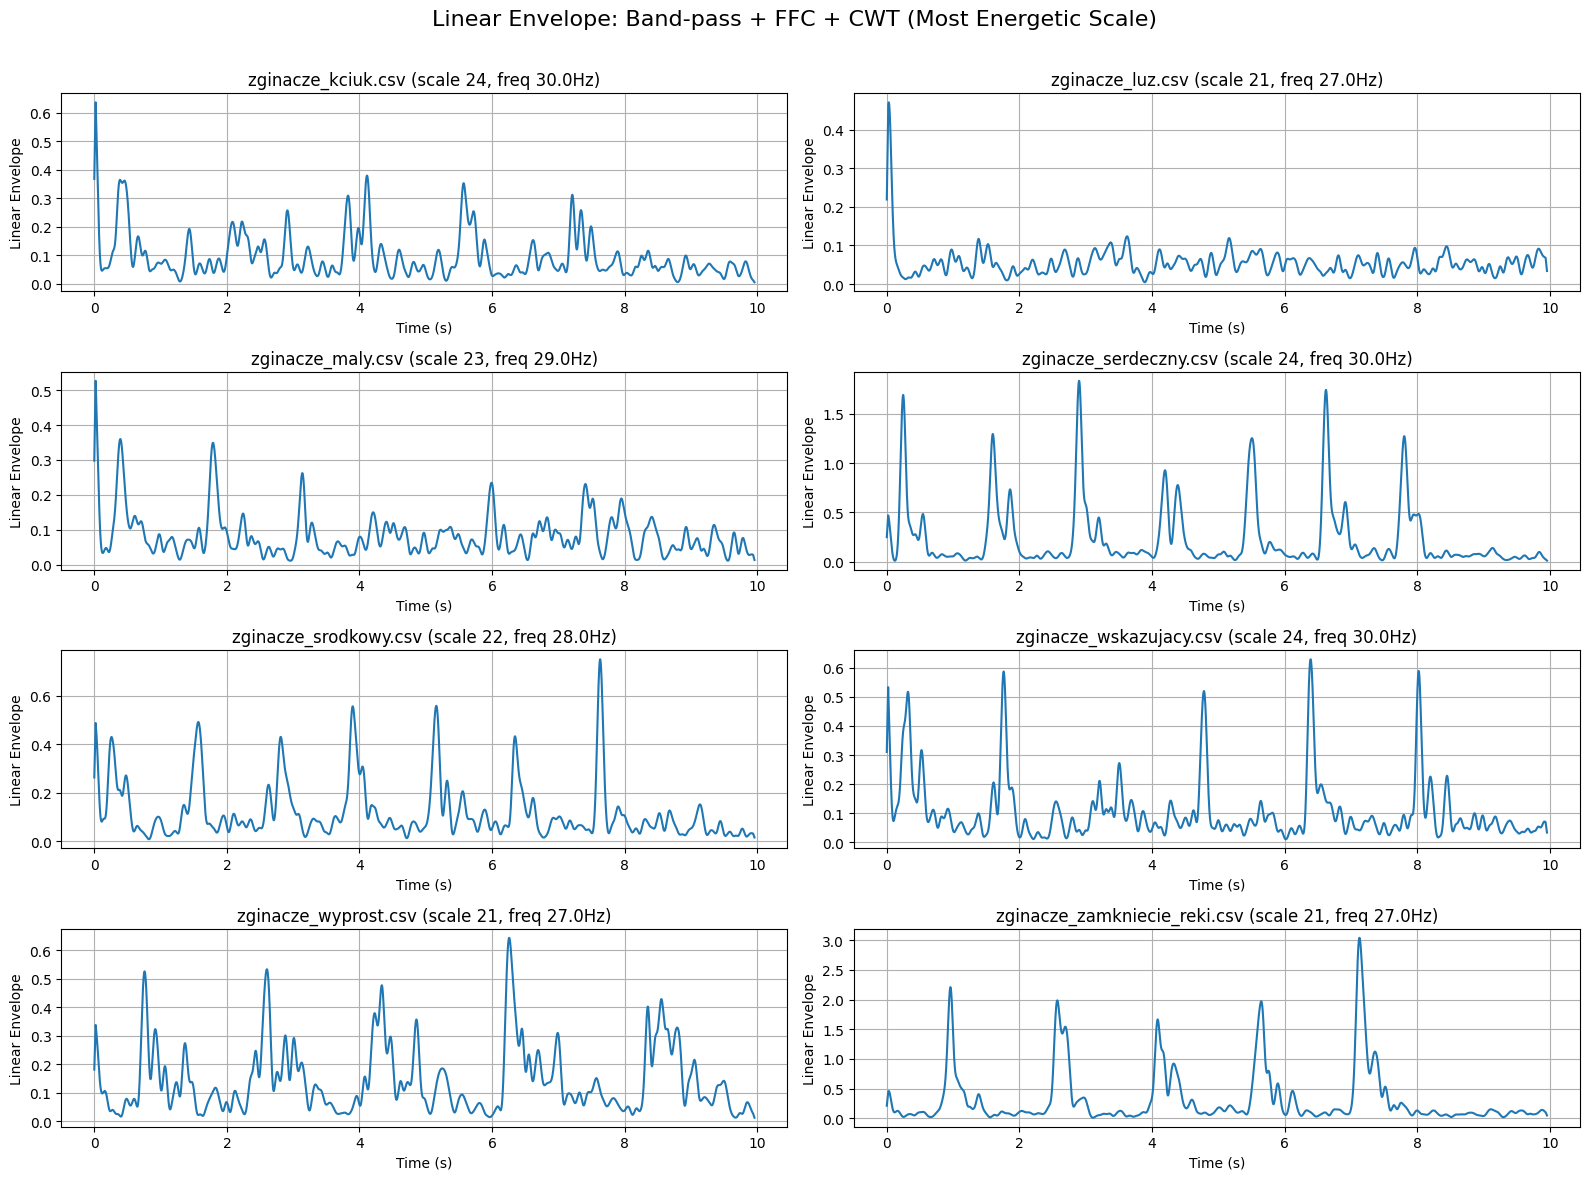

In [16]:
import math
from scipy.signal import butter, filtfilt

def linear_envelope(signal, fs, lowpass_cutoff=10.0, window_size=101):
    # Rectify
    rectified = np.abs(signal)
    # Low-pass filter
    nyquist = 0.5 * fs
    norm_cutoff = lowpass_cutoff / nyquist
    b, a = butter(2, norm_cutoff, btype='low')
    filtered = filtfilt(b, a, rectified)
    # Moving average smoothing
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(filtered, window, mode='same')
    return smoothed

# --- 1. Linear envelope for Band-pass + FFC ---
envelopes_1 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: comb + bandpass
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    envelope = linear_envelope(filtered_signal, fs)
    envelopes_1.append((time, envelope, filename))

# --- 2. Linear envelope for Band-pass + CWT (most energetic scale) ---
envelopes_2 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: bandpass only
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, adc_values)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    envelope = linear_envelope(real_cwt, fs)
    envelopes_2.append((time, envelope, f"{filename} (scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)"))

# --- 3. Linear envelope for Band-pass + FFC + CWT (most energetic scale) ---
envelopes_3 = []
for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    time = np.arange(len(adc_values)) / fs
    # Filtering: comb + bandpass
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    envelope = linear_envelope(real_cwt, fs)
    envelopes_3.append((time, envelope, f"{filename} (scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)"))

# --- Plotting ---
def plot_envelopes(envelopes, title):
    num_files = len(envelopes)
    cols = 2
    rows = math.ceil(num_files / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 3*rows), sharex=False)
    axs = axs.flatten()
    for i, (time, envelope, label) in enumerate(envelopes):
        axs[i].plot(time, envelope)
        axs[i].set_title(label)
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Linear Envelope")
        axs[i].grid(True)
    for j in range(num_files, len(axs)):
        fig.delaxes(axs[j])
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_envelopes(envelopes_1, "Linear Envelope: Band-pass + FFC")
plot_envelopes(envelopes_2, "Linear Envelope: Band-pass + CWT (Most Energetic Scale)")
plot_envelopes(envelopes_3, "Linear Envelope: Band-pass + FFC + CWT (Most Energetic Scale)")

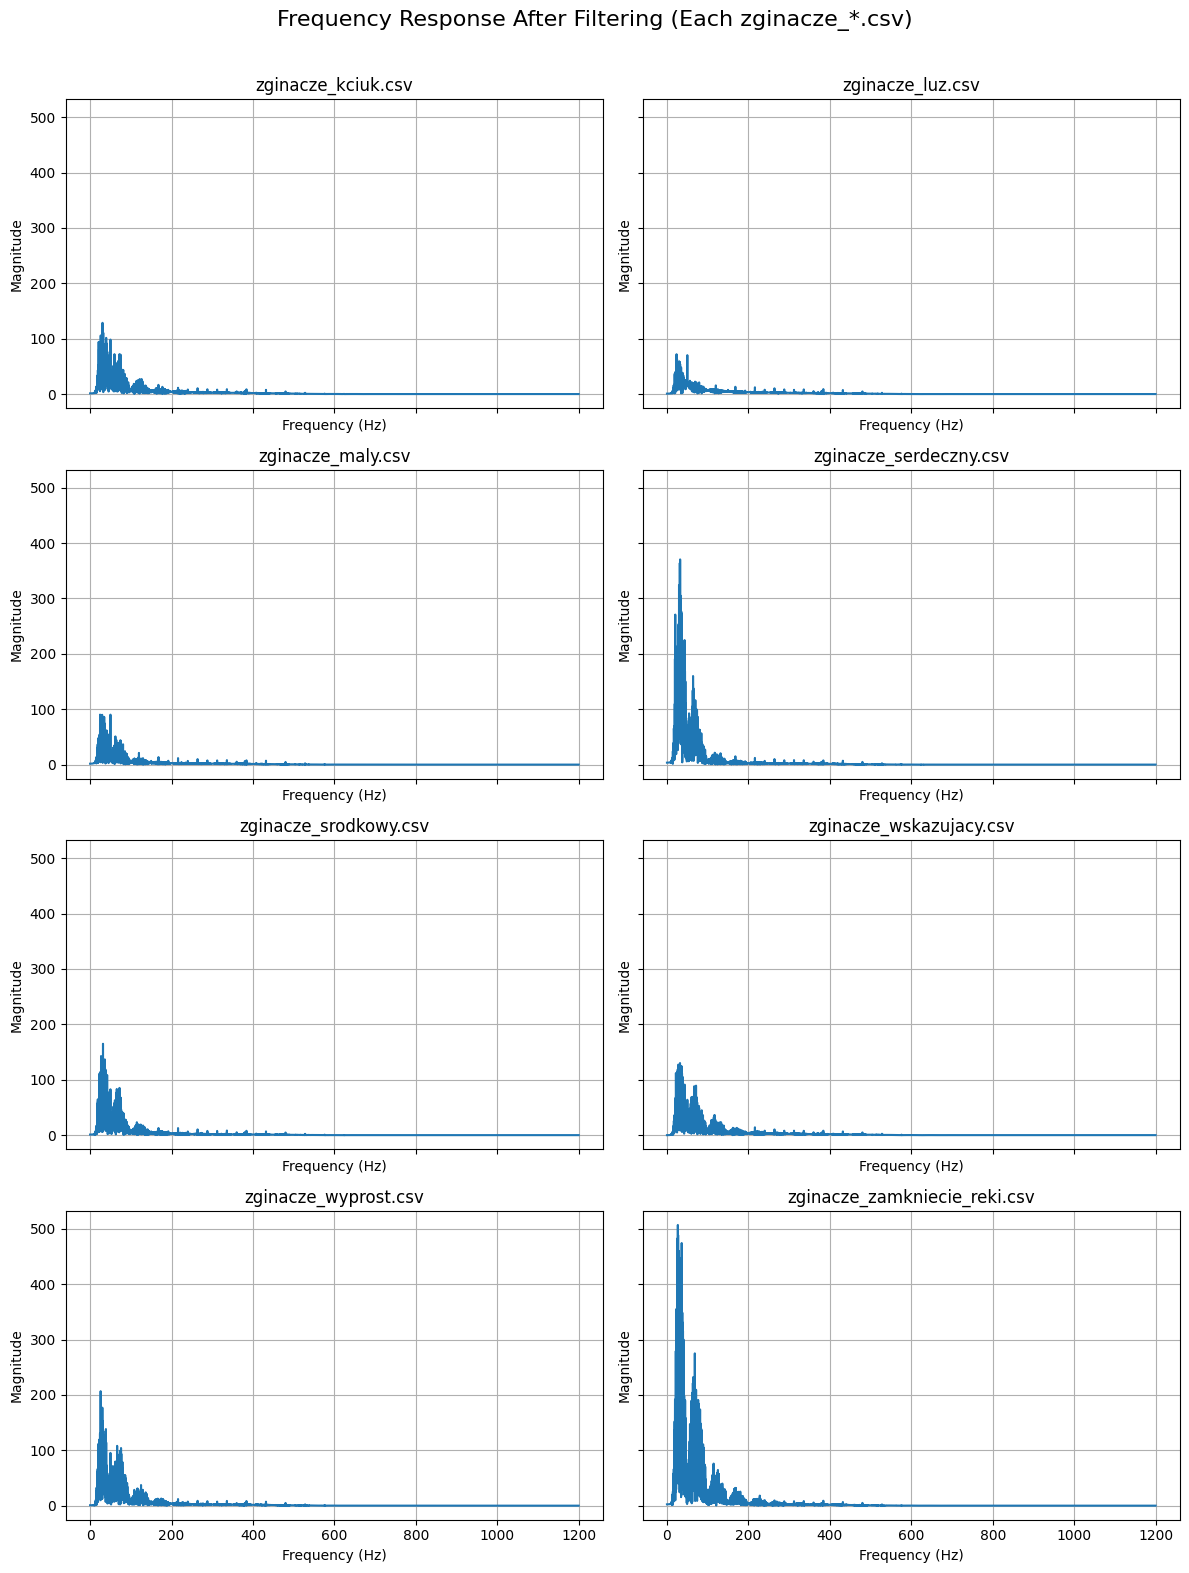

In [ ]:
import math

# Collect FFT of filtered signals for all files
filtered_fft_data = []
filtered_fft_freqs = []
file_labels = []

for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    # Filtering
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    # FFT of filtered signal
    n = len(filtered_signal)
    fft_signal = np.fft.fft(filtered_signal)
    fft_freq = np.fft.fftfreq(n, d=1/fs)
    filtered_fft_data.append(np.abs(fft_signal)[:n//2])
    filtered_fft_freqs.append(fft_freq[:n//2])
    file_labels.append(filename)

# Plot all filtered frequency responses in separate subplots in one figure
num_files = len(csv_files)
cols = 2  # or 3, depending on your preference
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(num_files):
    axs[i].plot(filtered_fft_freqs[i], filtered_fft_data[i])
    axs[i].set_title(file_labels[i])
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Magnitude")
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_files, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Frequency Response After Filtering Band-Pass + FFC (Each zginacze_*.csv)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

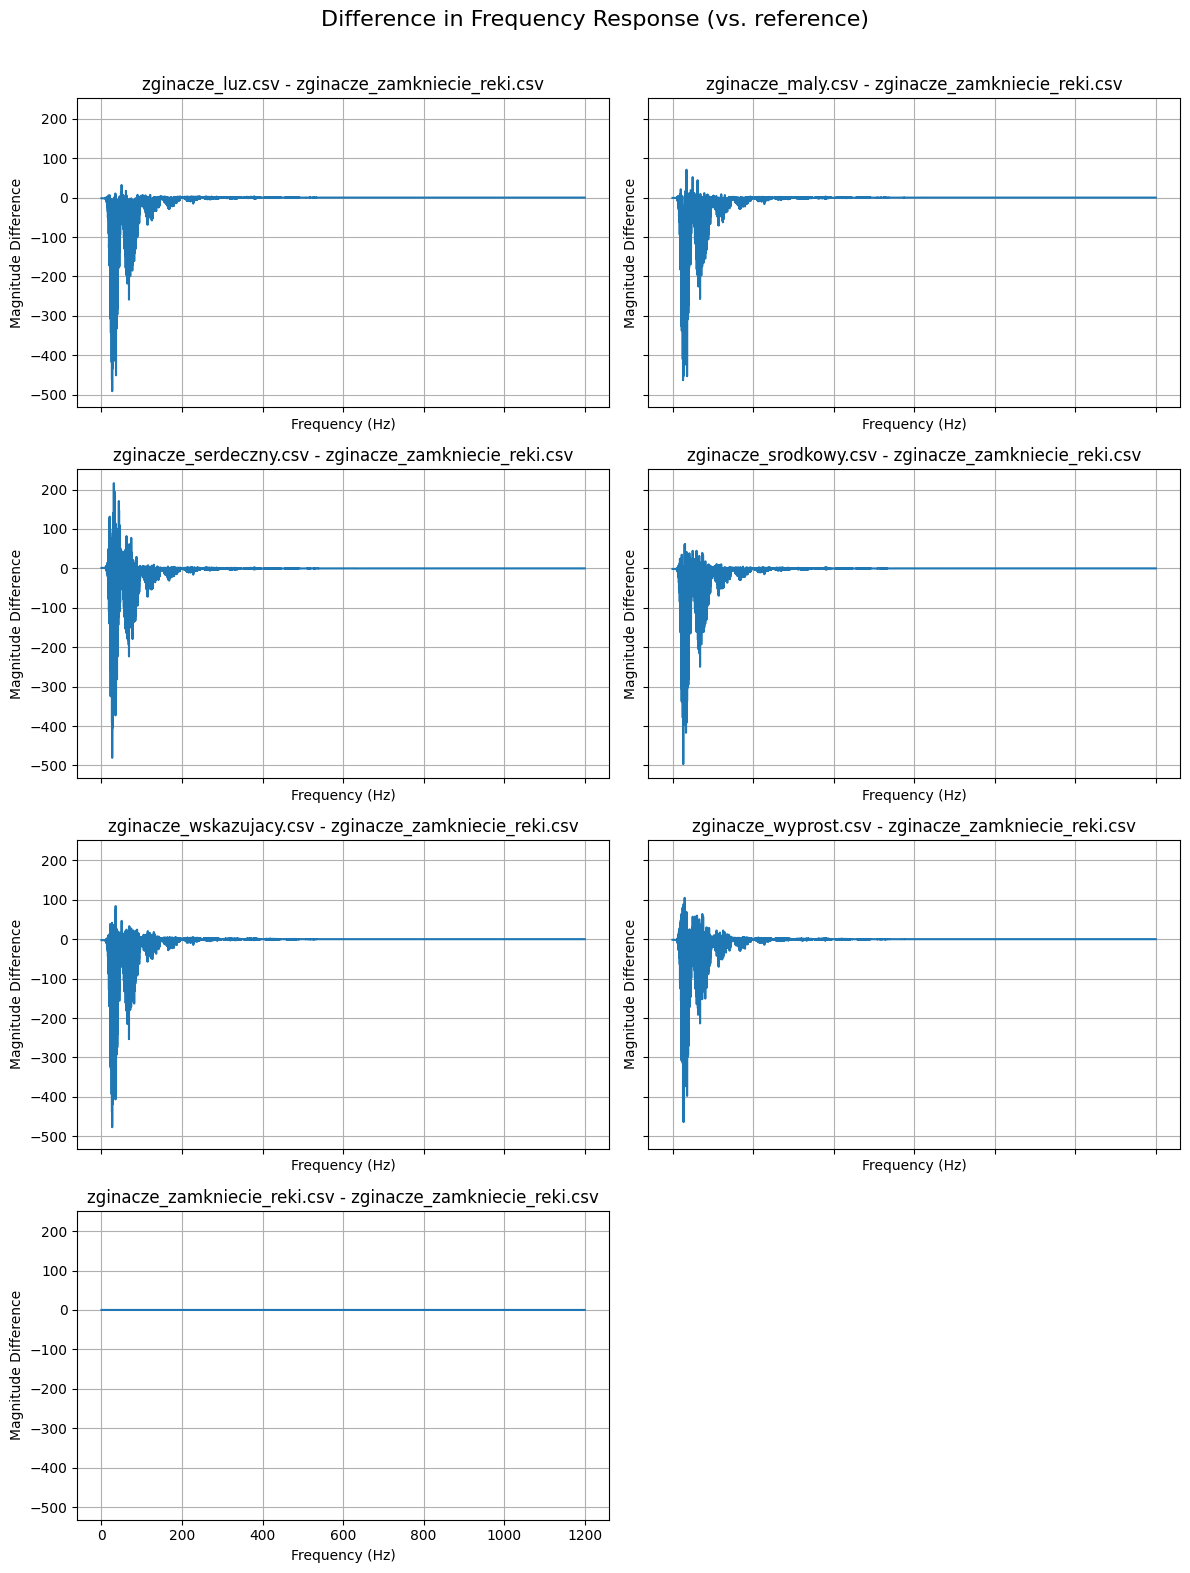

In [ ]:
# Plot difference in frequency response between files
# Reference: first file
reference_file_nr = 7
ref_fft = filtered_fft_data[reference_file_nr]
ref_freq = filtered_fft_freqs[reference_file_nr]
ref_label = file_labels[reference_file_nr]

num_files = len(filtered_fft_data)
cols = 2
rows = int(np.ceil((num_files - 1) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(1, num_files):
    # Interpolate to reference frequency axis if needed (for safety)
    interp_fft = np.interp(ref_freq, filtered_fft_freqs[i], filtered_fft_data[i])
    diff = interp_fft - ref_fft
    axs[i-1].plot(ref_freq, diff)
    axs[i-1].set_title(f"{file_labels[i]} - {ref_label}")
    axs[i-1].set_xlabel("Frequency (Hz)")
    axs[i-1].set_ylabel("Magnitude Difference")
    axs[i-1].grid(True)

# Hide unused subplots
for j in range(num_files-1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Difference in Frequency Response (vs. reference)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

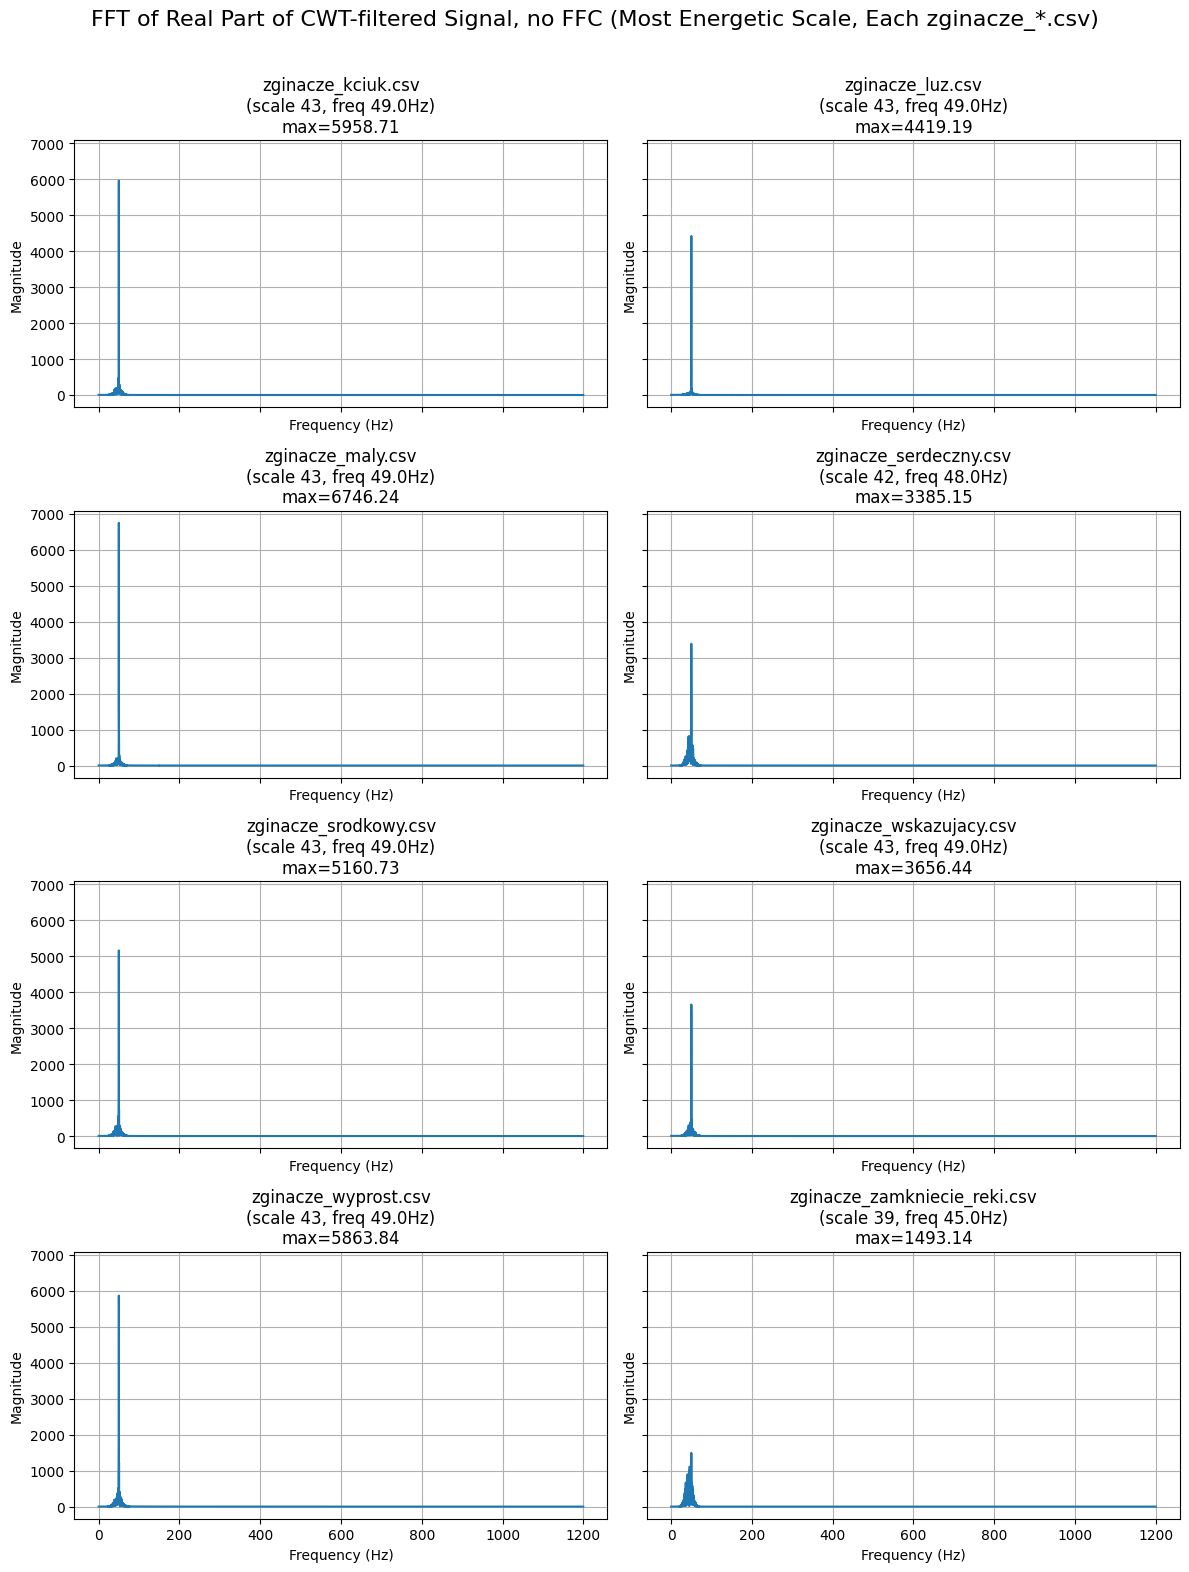

In [18]:
import math

cwt_fft_data = []
cwt_fft_freqs = []
cwt_labels = []
selected_scales = []

for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    # Filtering
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    #filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, adc_values)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    # Find the scale with the highest mean absolute value
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    selected_scales.append(best_scale_idx)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    # FFT of real CWT
    n = len(real_cwt)
    fft_signal = np.fft.fft(real_cwt)
    fft_freq = np.fft.fftfreq(n, d=1/fs)
    fft_magnitude = np.abs(fft_signal)[:n//2]
    max_magnitude = np.max(fft_magnitude)
    cwt_fft_data.append(fft_magnitude)
    cwt_fft_freqs.append(fft_freq[:n//2])
    cwt_labels.append(f"{filename}\n(scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)\nmax={max_magnitude:.2f}")

# Plot all CWT-real FFTs in separate subplots
num_files = len(csv_files)
cols = 2
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(num_files):
    axs[i].plot(cwt_fft_freqs[i], cwt_fft_data[i])
    axs[i].set_title(cwt_labels[i])
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Magnitude")
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_files, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("FFT of Real Part of CWT-filtered Signal, no FFC (Most Energetic Scale, Each zginacze_*.csv)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

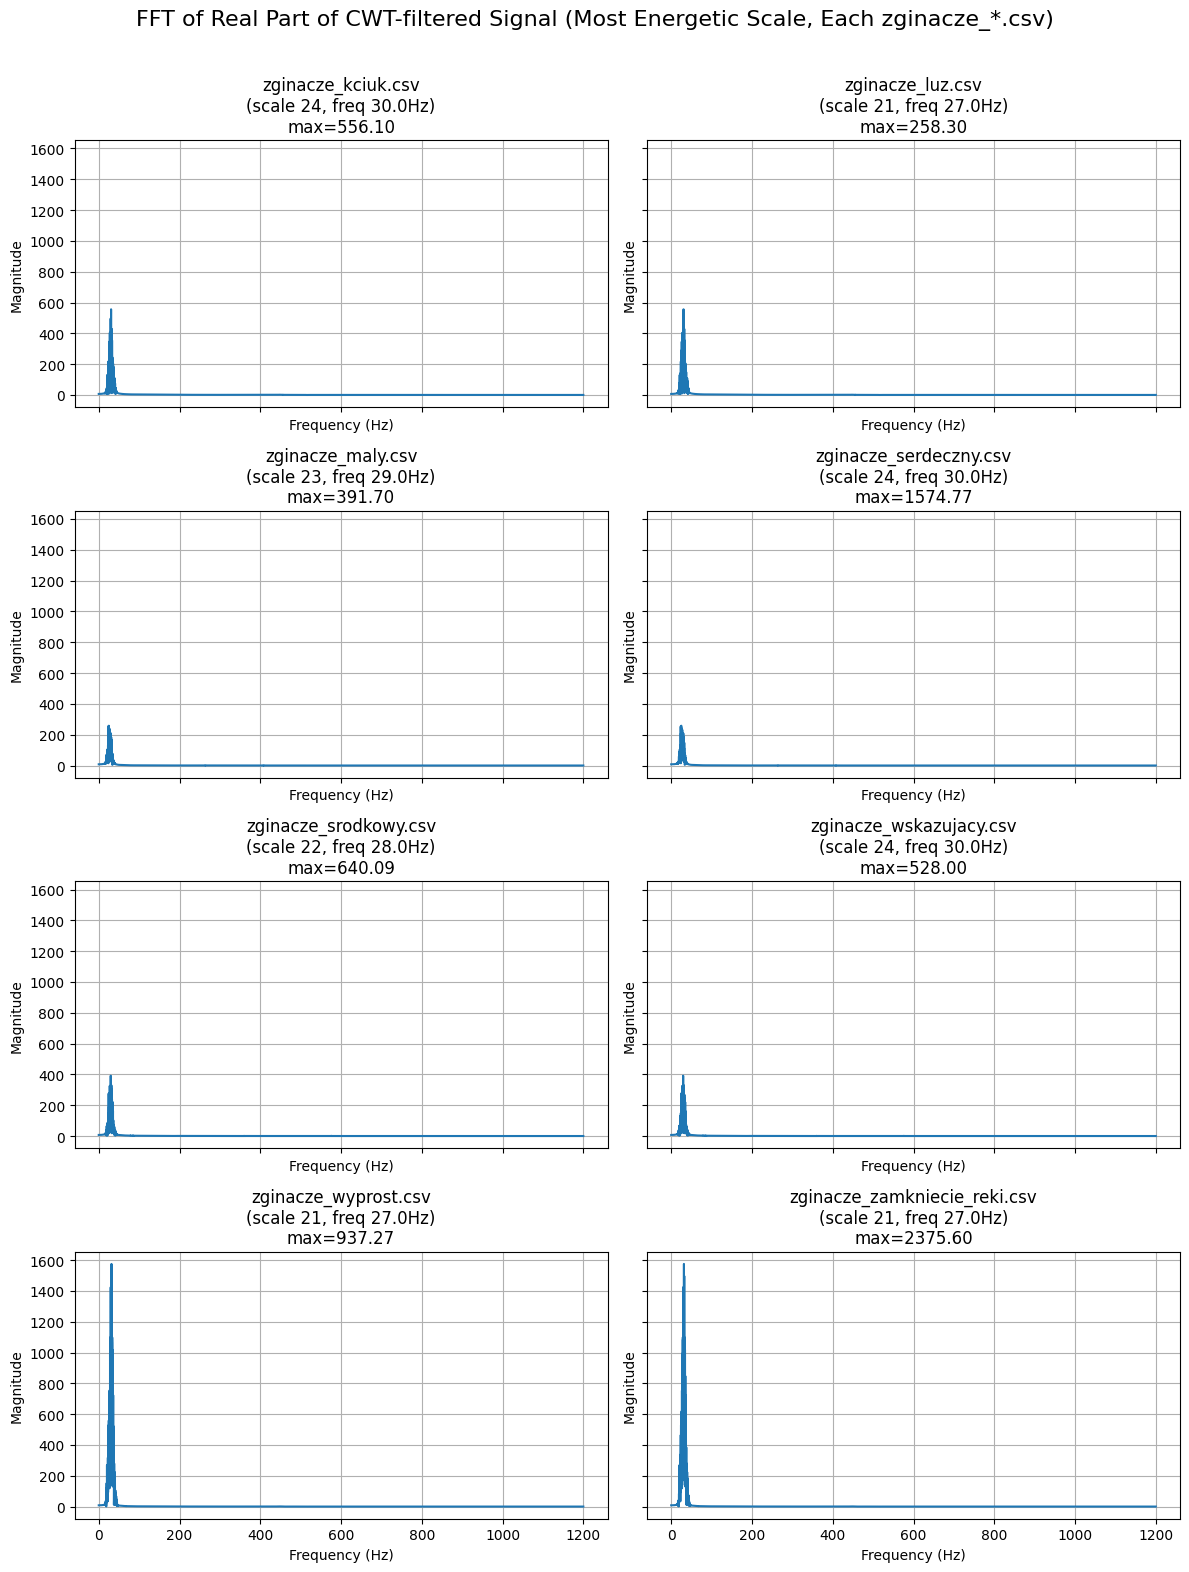

In [19]:
import math

cwt_fft_data = []
cwt_fft_freqs = []
cwt_labels = []
selected_scales = []

for filename in csv_files:
    adc_values = pd.read_csv(filename, header=None).squeeze()
    adc_values = adc_values[100:].reset_index(drop=True)
    # Filtering
    def comb_filter(signal, delay, alpha):
        b = np.zeros(delay + 1)
        b[0] = 1
        b[-1] = -alpha
        a = [1]
        return lfilter(b, a, signal)
    delay = int(fs / 50)
    alpha = 0.95
    filtered_signal_FFC = comb_filter(adc_values, delay, alpha)
    lowcut = 20.0
    highcut = 500.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, filtered_signal_FFC)
    # CWT
    B = 1.5
    C = 1.0
    wavelet = 'cmor'+str(B)+'-'+str(C)
    dt = 1/fs
    all_frequencies = np.arange(6, 500)
    frequencies = all_frequencies / fs
    scales = pywt.frequency2scale(wavelet, frequencies)
    cwtmatr, freqs = pywt.cwt(filtered_signal, scales, wavelet, sampling_period=dt)
    # Find the scale with the highest mean absolute value
    mean_abs = np.mean(np.abs(cwtmatr), axis=1)
    best_scale_idx = np.argmax(mean_abs)
    selected_scales.append(best_scale_idx)
    real_cwt = np.real(cwtmatr[best_scale_idx, :])
    # FFT of real CWT
    n = len(real_cwt)
    fft_signal = np.fft.fft(real_cwt)
    fft_freq = np.fft.fftfreq(n, d=1/fs)
    cwt_fft_data.append(np.abs(fft_signal)[:n//2])
    cwt_fft_freqs.append(fft_freq[:n//2])
    fft_magnitude = np.abs(fft_signal)[:n//2]
    max_magnitude = np.max(fft_magnitude)
    cwt_fft_data.append(fft_magnitude)
    cwt_fft_freqs.append(fft_freq[:n//2])
    cwt_labels.append(f"{filename}\n(scale {best_scale_idx}, freq {freqs[best_scale_idx]:.1f}Hz)\nmax={max_magnitude:.2f}")

# Plot all CWT-real FFTs in separate subplots
num_files = len(csv_files)
cols = 2
rows = math.ceil(num_files / cols)

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(num_files):
    axs[i].plot(cwt_fft_freqs[i], cwt_fft_data[i])
    axs[i].set_title(cwt_labels[i])
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Magnitude")
    axs[i].grid(True)

# Hide any unused subplots
for j in range(num_files, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("FFT of Real Part of CWT-filtered Signal (Most Energetic Scale, Each zginacze_*.csv)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()